In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import time
import ghalton
import numpy as np

In [3]:
'''
Helper function that cleans up list_directory
removes hidden files
'''
def clean(lis):
    try:
        
        lis.remove('.DS_Store')
    except:
        lis = lis
    return lis

'''
Helper function that retrieves all data files
cleans up the directory to leave only .dat files
'''
def get_files(lis):
    try:
        for i in list(lis):
            if('.dat' not in i):
                lis.remove(i)
    except:
        lis = lis
    return lis

In [4]:
path = '/Users/zyzdiana/Dropbox/Spring2015/AC297r/Pineapple_images/'
files = get_files(os.listdir(path))
print files

['Pos_1_Vol_1.dat', 'Pos_1_Vol_2.dat', 'Pos_1_Vol_3.dat', 'Pos_1_Vol_4.dat', 'Pos_1_Vol_5.dat', 'Pos_2_Vol_1.dat', 'Pos_2_Vol_2.dat', 'Pos_2_Vol_3.dat', 'Pos_2_Vol_4.dat', 'Pos_2_Vol_5.dat']


# Trilinear Interpolation #

<img src = "./trilinear_interp0.png" height="200" width="200">

For trilinear interpolation on a 3D grid, we need to estimate voxel value at point $c = (x,y,z)$ with 8 known surrounding points that defines a box around the unkown point. 

This probelm can be mapped down to two bilinear interpolation and a linear interpolation. We see that point $C_1$ is the result of bilinear interpolation formed on the surface with points $C_{001}, C_{011},C_{101}, \textrm{and } C_{111}$, and point $C_0$ is the result of bilinear interpolation formed on the surface with points $C_{000}, C_{100},C_{110}, \textrm{and } C_{010}$. With $C_0 = (x_{c_0}, y_{c_0}, z_{c_0})$ and $C_1 = (x_{c_1}, y_{c_1}, z_{c_1})$, we can estimate c with a simple linear inperpolation, 

$$f(c) = \frac{z_{c_1}-z}{z_{c_1}-z_{c_0}}f(C_0) + \frac{z-z_{c_0}}{z_{c_1}-z_{c_0}}f(C_1)$$

We are dealing with integer grid here, so $z_{c_1}-z_{c_0} = 1$, and hence the interpolation reduces to

$$f(c) = (z_{c_1}-z)\cdot f(C_0) + (z-z_{c_0}) \cdot f(C_1)$$ 

<img src = "./trilinear_interp1.png">

In [5]:
def trilinear_interp(volume, x, y, z):
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    
    # find the closest grid of the target points
    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1
    z0 = np.floor(z).astype(int)
    z1 = z0 + 1
    
    # Clip
    x0 = x0.clip(0, volume.shape[0]-1)
    x1 = x1.clip(0, volume.shape[0]-1)
    y0 = y0.clip(0, volume.shape[1]-1)
    y1 = y1.clip(0, volume.shape[1]-1)
    z0 = z0.clip(0, volume.shape[2]-1)
    z1 = z1.clip(0, volume.shape[2]-1)    

    # define some coefficients
    xd = x-x0
    yd = y-y0
    zd = z-z0
    
    # set up for the bilinear interpolation
    C00 = volume[y0,x0,z0]*(1-xd) + volume[y0,x1,z0]*xd
    C10 = volume[y1,x0,z0]*(1-xd) + volume[y1,x1,z0]*xd
    
    C01 = volume[y0,x0,z1]*(1-xd) + volume[y0,x1,z1]*xd
    C11 = volume[y1,x0,z1]*(1-xd) + volume[y1,x1,z1]*xd
    
    C0 = C00*(1-yd) + C10*yd
    C1 = C01*(1-yd) + C11*yd
    
    C = C0*(1-zd) + C1*zd
    return C

###Test Trilinear Interpolation###

In [6]:
vol1 = np.memmap(path+files[0], dtype=np.float32, mode='c', shape=(32,32,32))
vol1 = np.array(vol1)
vol2 = np.memmap(path+files[5], dtype=np.float32, mode='c', shape=(32,32,32))
vol2 = np.array(vol2)

time for interpolation with 100 point is 0.604642152786 seconds


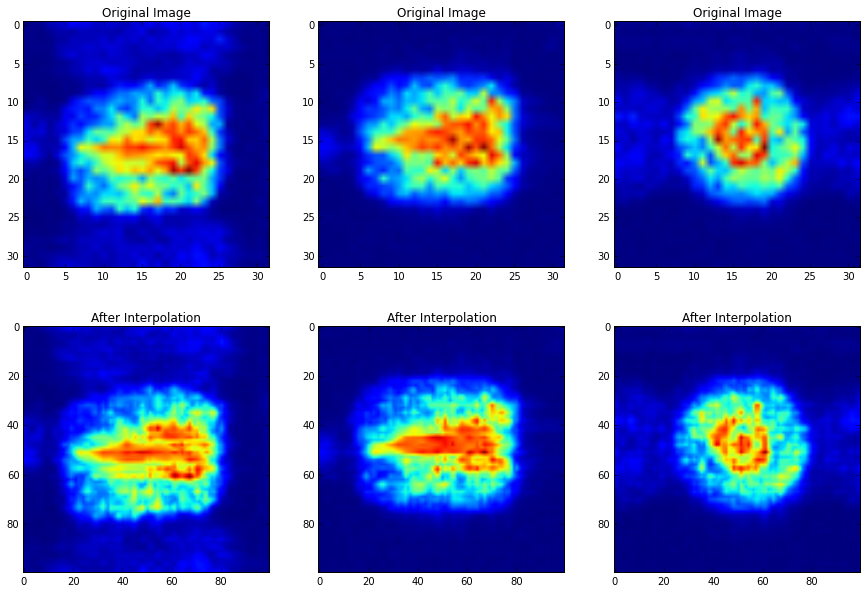

In [7]:
# create meshgrid for interpolation
n = 100
grid_x, grid_y, grid_z = np.meshgrid(np.linspace(0,31,n),np.linspace(0,31,n),np.linspace(0,31,n))

# time the interpolation for reference
t0 = time.time()
# interpolate vol1 and vol2 on the same grid
vol1_tri = trilinear_interp(vol1, grid_x, grid_y, grid_z)
vol2_tri = trilinear_interp(vol2, grid_x, grid_y, grid_z)
t1 = time.time()
print "time for interpolation with %s point is %s seconds" % (n,t1-t0)

# plot results
fig, ax = plt.subplots(2,3)
fig.set_figwidth(15)
fig.set_figheight(10)
[ax[0][i].imshow(vol1.max(axis=i)) for i in xrange(3)]
[ax[0][i].set_title('Original Image') for i in xrange(3)]
[ax[1][i].imshow(vol1_tri.max(axis=i)) for i in xrange(3)]
[ax[1][i].set_title('After Interpolation') for i in xrange(3)]
plt.show()
plt.close(fig)

#Tricubic Interpolation#

try looping through so save memory.

$$f(x,y,z)=\sum_{i=0}^3 \sum_{j=0}^3 \sum_{k=0}^3 a_{ijk} x^i y^j z^k$$

In [8]:
X_inv =np.array([
( 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
(-3, 3, 0, 0, 0, 0, 0, 0,-2,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 2,-2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
(-3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0,-3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 9,-9,-9, 9, 0, 0, 0, 0, 6, 3,-6,-3, 0, 0, 0, 0, 6,-6, 3,-3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
(-6, 6, 6,-6, 0, 0, 0, 0,-3,-3, 3, 3, 0, 0, 0, 0,-4, 4,-2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2,-2,-1,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 2, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
(-6, 6, 6,-6, 0, 0, 0, 0,-4,-2, 4, 2, 0, 0, 0, 0,-3, 3,-3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2,-1,-2,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 4,-4,-4, 4, 0, 0, 0, 0, 2, 2,-2,-2, 0, 0, 0, 0, 2,-2, 2,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 3, 0, 0, 0, 0, 0, 0,-2,-1, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,-2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0,-1, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9,-9,-9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 3,-6,-3, 0, 0, 0, 0, 6,-6, 3,-3, 0, 0, 0, 0, 4, 2, 2, 1, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-6, 6, 6,-6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3,-3, 3, 3, 0, 0, 0, 0,-4, 4,-2, 2, 0, 0, 0, 0,-2,-2,-1,-1, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-6, 6, 6,-6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-4,-2, 4, 2, 0, 0, 0, 0,-3, 3,-3, 3, 0, 0, 0, 0,-2,-1,-2,-1, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,-4,-4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,-2,-2, 0, 0, 0, 0, 2,-2, 2,-2, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0),
(-3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0,-3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 9,-9, 0, 0,-9, 9, 0, 0, 6, 3, 0, 0,-6,-3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6,-6, 0, 0, 3,-3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
(-6, 6, 0, 0, 6,-6, 0, 0,-3,-3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-4, 4, 0, 0,-2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2,-2, 0, 0,-1,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0, 0, 0,-1, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9,-9, 0, 0,-9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 3, 0, 0,-6,-3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6,-6, 0, 0, 3,-3, 0, 0, 4, 2, 0, 0, 2, 1, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-6, 6, 0, 0, 6,-6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3,-3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-4, 4, 0, 0,-2, 2, 0, 0,-2,-2, 0, 0,-1,-1, 0, 0),
( 9, 0,-9, 0,-9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 3, 0,-6, 0,-3, 0, 6, 0,-6, 0, 3, 0,-3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,-9, 0,-9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 3, 0,-6, 0,-3, 0, 6, 0,-6, 0, 3, 0,-3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 2, 0, 1, 0),
(-27,27,27,-27,27,-27,-27,27,-18,-9,18, 9,18, 9,-18,-9,-18,18,-9, 9,18,-18, 9,-9,-18,18,18,-18,-9, 9, 9,-9,-12,-6,-6,-3,12, 6, 6, 3,-12,-6,12, 6,-6,-3, 6, 3,-12,12,-6, 6,-6, 6,-3, 3,-8,-4,-4,-2,-4,-2,-2,-1),
(18,-18,-18,18,-18,18,18,-18, 9, 9,-9,-9,-9,-9, 9, 9,12,-12, 6,-6,-12,12,-6, 6,12,-12,-12,12, 6,-6,-6, 6, 6, 6, 3, 3,-6,-6,-3,-3, 6, 6,-6,-6, 3, 3,-3,-3, 8,-8, 4,-4, 4,-4, 2,-2, 4, 4, 2, 2, 2, 2, 1, 1),
(-6, 0, 6, 0, 6, 0,-6, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 0,-3, 0, 3, 0, 3, 0,-4, 0, 4, 0,-2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0,-2, 0,-1, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0,-6, 0, 6, 0, 6, 0,-6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 0,-3, 0, 3, 0, 3, 0,-4, 0, 4, 0,-2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0,-2, 0,-1, 0,-1, 0),
(18,-18,-18,18,-18,18,18,-18,12, 6,-12,-6,-12,-6,12, 6, 9,-9, 9,-9,-9, 9,-9, 9,12,-12,-12,12, 6,-6,-6, 6, 6, 3, 6, 3,-6,-3,-6,-3, 8, 4,-8,-4, 4, 2,-4,-2, 6,-6, 6,-6, 3,-3, 3,-3, 4, 2, 4, 2, 2, 1, 2, 1),
(-12,12,12,-12,12,-12,-12,12,-6,-6, 6, 6, 6, 6,-6,-6,-6, 6,-6, 6, 6,-6, 6,-6,-8, 8, 8,-8,-4, 4, 4,-4,-3,-3,-3,-3, 3, 3, 3, 3,-4,-4, 4, 4,-2,-2, 2, 2,-4, 4,-4, 4,-2, 2,-2, 2,-2,-2,-2,-2,-1,-1,-1,-1),
( 2, 0, 0, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
(-6, 6, 0, 0, 6,-6, 0, 0,-4,-2, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 3, 0, 0,-3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2,-1, 0, 0,-2,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 4,-4, 0, 0,-4, 4, 0, 0, 2, 2, 0, 0,-2,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,-2, 0, 0, 2,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-6, 6, 0, 0, 6,-6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-4,-2, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-3, 3, 0, 0,-3, 3, 0, 0,-2,-1, 0, 0,-2,-1, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,-4, 0, 0,-4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,-2,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,-2, 0, 0, 2,-2, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0),
(-6, 0, 6, 0, 6, 0,-6, 0, 0, 0, 0, 0, 0, 0, 0, 0,-4, 0,-2, 0, 4, 0, 2, 0,-3, 0, 3, 0,-3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0,-1, 0,-2, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0,-6, 0, 6, 0, 6, 0,-6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-4, 0,-2, 0, 4, 0, 2, 0,-3, 0, 3, 0,-3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,-2, 0,-1, 0,-2, 0,-1, 0),
(18,-18,-18,18,-18,18,18,-18,12, 6,-12,-6,-12,-6,12, 6,12,-12, 6,-6,-12,12,-6, 6, 9,-9,-9, 9, 9,-9,-9, 9, 8, 4, 4, 2,-8,-4,-4,-2, 6, 3,-6,-3, 6, 3,-6,-3, 6,-6, 3,-3, 6,-6, 3,-3, 4, 2, 2, 1, 4, 2, 2, 1),
(-12,12,12,-12,12,-12,-12,12,-6,-6, 6, 6, 6, 6,-6,-6,-8, 8,-4, 4, 8,-8, 4,-4,-6, 6, 6,-6,-6, 6, 6,-6,-4,-4,-2,-2, 4, 4, 2, 2,-3,-3, 3, 3,-3,-3, 3, 3,-4, 4,-2, 2,-4, 4,-2, 2,-2,-2,-1,-1,-2,-2,-1,-1),
( 4, 0,-4, 0,-4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,-2, 0,-2, 0, 2, 0,-2, 0, 2, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0),
( 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,-4, 0,-4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,-2, 0,-2, 0, 2, 0,-2, 0, 2, 0,-2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0),
(-12,12,12,-12,12,-12,-12,12,-8,-4, 8, 4, 8, 4,-8,-4,-6, 6,-6, 6, 6,-6, 6,-6,-6, 6, 6,-6,-6, 6, 6,-6,-4,-2,-4,-2, 4, 2, 4, 2,-4,-2, 4, 2,-4,-2, 4, 2,-3, 3,-3, 3,-3, 3,-3, 3,-2,-1,-2,-1,-2,-1,-2,-1),
( 8,-8,-8, 8,-8, 8, 8,-8, 4, 4,-4,-4,-4,-4, 4, 4, 4,-4, 4,-4,-4, 4,-4, 4, 4,-4,-4, 4, 4,-4,-4, 4, 2, 2, 2, 2,-2,-2,-2,-2, 2, 2,-2,-2, 2, 2,-2,-2, 2,-2, 2,-2, 2,-2, 2,-2, 1, 1, 1, 1, 1, 1, 1, 1)
])

In [9]:
def get_target_Y(x, y, z):
    Y = np.zeros([len(x),64])
    Y[:,0] = 1.
    Y[:,1] = x
    Y[:,2] = x**2
    Y[:,3] = x**3
    Y[:,4] = y
    Y[:,5] = x*y
    Y[:,6] = x**2*y
    Y[:,7] = x**3*y
    Y[:,8] = y**2
    Y[:,9] = x*y**2
    Y[:,10] = x**2*y**2
    Y[:,11] = x**3*y**2
    Y[:,12] = y**3
    Y[:,13] = x*y**3
    Y[:,14] = x**2*y**3
    Y[:,15] = x**3*y**3
    

    Y[:,16] = z
    Y[:,17] = x*z
    Y[:,18] = x**2*z
    Y[:,19] = x**3*z
    Y[:,20] = y*z
    Y[:,21] = x*y*z
    Y[:,22] = x**2*y*z
    Y[:,23] = x**3*y*z
    Y[:,24] = y**2*z
    Y[:,25] = x*y**2*z
    Y[:,26] = x**2*y**2*z
    Y[:,27] = x**3*y**2*z
    Y[:,28] = y**3*z
    Y[:,29] = x*y**3*z
    Y[:,30] = x**2*y**3*z
    Y[:,31] = x**3*y**3*z
    
    Y[:,32] = z**2
    Y[:,33] = x*z**2
    Y[:,34] = x**2*z**2
    Y[:,35] = x**3*z**2
    Y[:,36] = y*z**2
    Y[:,37] = x*y*z**2
    Y[:,38] = x**2*y*z**2
    Y[:,39] = x**3*y*z**2
    Y[:,40] = y**2*z**2
    Y[:,41] = x*y**2*z**2
    Y[:,42] = x**2*y**2*z**2
    Y[:,43] = x**3*y**2*z**2
    Y[:,44] = y**3*z**2
    Y[:,45] = x*y**3*z**2
    Y[:,46] = x**2*y**3*z**2
    Y[:,47] = x**3*y**3*z**2
    
    Y[:,48] = z**3
    Y[:,49] = x*z**3
    Y[:,50] = x**2*z**3
    Y[:,51] = x**3*z**3
    Y[:,52] = y*z**3
    Y[:,53] = x*y*z**3
    Y[:,54] = x**2*y*z**3
    Y[:,55] = x**3*y*z**3
    Y[:,56] = y**2*z**3
    Y[:,57] = x*y**2*z**3
    Y[:,58] = x**2*y**2*z**3
    Y[:,59] = x**3*y**2*z**3
    Y[:,60] = y**3*z**3
    Y[:,61] = x*y**3*z**3
    Y[:,62] = x**2*y**3*z**3
    Y[:,63] = x**3*y**3*z**3

    return Y

In [15]:
def tricubic_interp(volume, x, y, z):
    xr = x.ravel()
    yr = y.ravel()
    zr = z.ravel()
    
    # find the closes grid of the target points
    x1 = np.floor(x).astype(int)
    
    # Take care of boundary conditions
    x0 = x1 - 1
    x2 = x1 + 1
    x3 = x2 + 1
    
    y1 = np.floor(y).astype(int)
    y0 = y1 - 1
    y2 = y1 + 1
    y3 = y2 + 1
        
    z1 = np.floor(z).astype(int)
    z0 = z1 - 1
    z2 = z1 + 1
    z3 = z2 + 1
    
    # we need to clip the range 
    x0 = np.clip(x0, 0, volume.shape[1]-1)
    x1 = np.clip(x1, 0, volume.shape[1]-1)
    x2 = np.clip(x2, 0, volume.shape[1]-1)
    x3 = np.clip(x3, 0, volume.shape[1]-1)
    y0 = np.clip(y0, 0, volume.shape[0]-1)
    y1 = np.clip(y1, 0, volume.shape[0]-1)
    y2 = np.clip(y2, 0, volume.shape[0]-1)
    y3 = np.clip(y3, 0, volume.shape[0]-1)
    z0 = np.clip(z0, 0, volume.shape[2]-1)
    z1 = np.clip(z1, 0, volume.shape[2]-1)
    z2 = np.clip(z2, 0, volume.shape[2]-1)
    z3 = np.clip(z3, 0, volume.shape[2]-1)
    
    # compute the vector of coefficients A
    # first compute vector Y from known points to solve for A
    Y = np.zeros([64,len(xr)])
    # values of f(x,y,z) at each corner.
    Y[0] = volume[y1,x1,z1].ravel()
    Y[1] = volume[y1,x2,z1].ravel()
    Y[2] = volume[y2,x1,z1].ravel()
    Y[3] = volume[y2,x2,z1].ravel()
    Y[4] = volume[y1,x1,z2].ravel()
    Y[5] = volume[y1,x2,z2].ravel()
    Y[6] = volume[y2,x1,z2].ravel()
    Y[7] = volume[y2,x2,z2].ravel()
    
    # values of df/dx at each corner.
    Y[8] = ((volume[y1,x2,z1]-volume[y1,x0,z1])/2.).ravel()
    Y[9] = ((volume[y1,x3,z1]-volume[y1,x1,z1])/2.).ravel()
    Y[10] = ((volume[y2,x2,z1]-volume[y2,x0,z1])/2.).ravel()
    Y[11] = ((volume[y2,x3,z1]-volume[y2,x1,z1])/2.).ravel()
    Y[12] = ((volume[y2,x1,z2]-volume[y0,x1,z2])/2.).ravel()
    Y[13] = ((volume[y2,x2,z2]-volume[y0,x2,z2])/2.).ravel()
    Y[14] = ((volume[y3,x1,z2]-volume[y1,x1,z2])/2.).ravel()
    Y[15] = ((volume[y3,x2,z2]-volume[y1,x2,z2])/2.).ravel()

    # values of df/dy at each corner.
    Y[16] = ((volume[y2,x1,z1]-volume[y0,x1,z1])/2.).ravel()
    Y[17] = ((volume[y2,x2,z1]-volume[y0,x2,z1])/2.).ravel()
    Y[18] = ((volume[y3,x1,z1]-volume[y1,x1,z1])/2.).ravel()
    Y[19] = ((volume[y3,x2,z1]-volume[y1,x2,z1])/2.).ravel()
    Y[20] = ((volume[y2,x1,z2]-volume[y0,x1,z2])/2.).ravel()
    Y[21] = ((volume[y2,x2,z2]-volume[y0,x2,z2])/2.).ravel()
    Y[22] = ((volume[y3,x1,z2]-volume[y1,x1,z2])/2.).ravel()
    Y[23] = ((volume[y3,x2,z2]-volume[y1,x2,z2])/2.).ravel()
    
    # values of df/dz at each corner.
    Y[24] = ((volume[y1,x1,z2]-volume[y1,x1,z0])/2.).ravel()
    Y[25] = ((volume[y1,x2,z2]-volume[y1,x2,z0])/2.).ravel()
    Y[26] = ((volume[y2,x1,z2]-volume[y2,x1,z0])/2.).ravel()
    Y[27] = ((volume[y2,x2,z2]-volume[y2,x2,z0])/2.).ravel()
    Y[28] = ((volume[y1,x1,z3]-volume[y1,x1,z1])/2.).ravel()
    Y[29] = ((volume[y1,x2,z3]-volume[y1,x2,z1])/2.).ravel()
    Y[30] = ((volume[y2,x1,z3]-volume[y2,x1,z1])/2.).ravel()
    Y[31] = ((volume[y2,x2,z3]-volume[y2,x2,z1])/2.).ravel()
    
    # values of d2f/dxdy at each corner.
    Y[32] = ((volume[y2,x2,z1]-volume[y2,x0,z1]-volume[y0,x2,z1]+volume[y0,x0,z1])/4.).ravel()
    Y[33] = ((volume[y2,x3,z1]-volume[y2,x1,z1]-volume[y0,x3,z1]+volume[y0,x1,z1])/4.).ravel()
    Y[34] = ((volume[y3,x2,z1]-volume[y3,x0,z1]-volume[y1,x2,z1]+volume[y1,x0,z1])/4.).ravel()
    Y[35] = ((volume[y3,x3,z1]-volume[y3,x1,z1]-volume[y1,x3,z1]+volume[y1,x1,z1])/4.).ravel()
    Y[36] = ((volume[y2,x2,z2]-volume[y2,x0,z2]-volume[y0,x2,z2]+volume[y0,x0,z2])/4.).ravel()
    Y[37] = ((volume[y2,x3,z2]-volume[y2,x1,z2]-volume[y0,x3,z2]+volume[y0,x1,z2])/4.).ravel()
    Y[38] = ((volume[y3,x2,z2]-volume[y3,x0,z2]-volume[y1,x2,z2]+volume[y1,x0,z2])/4.).ravel()
    Y[39] = ((volume[y3,x3,z2]-volume[y3,x1,z2]-volume[y1,x3,z2]+volume[y1,x1,z2])/4.).ravel()

    # values of d2f/dxdz at each corner.
    Y[40] = ((volume[y1,x2,z2]-volume[y1,x0,z2]-volume[y1,x2,z0]+volume[y1,x0,z0])/4.).ravel()
    Y[41] = ((volume[y1,x3,z2]-volume[y1,x1,z2]-volume[y1,x3,z0]+volume[y1,x1,z0])/4.).ravel()
    Y[42] = ((volume[y2,x2,z2]-volume[y2,x0,z2]-volume[y2,x2,z0]+volume[y2,x0,z0])/4.).ravel()
    Y[43] = ((volume[y2,x3,z2]-volume[y2,x1,z2]-volume[y2,x3,z0]+volume[y2,x1,z0])/4.).ravel()
    Y[44] = ((volume[y1,x2,z3]-volume[y1,x0,z3]-volume[y1,x2,z1]+volume[y1,x0,z1])/4.).ravel()
    Y[45] = ((volume[y1,x3,z3]-volume[y1,x1,z3]-volume[y1,x3,z1]+volume[y1,x1,z1])/4.).ravel()
    Y[46] = ((volume[y2,x2,z3]-volume[y2,x0,z3]-volume[y2,x2,z1]+volume[y2,x0,z1])/4.).ravel()
    Y[47] = ((volume[y2,x3,z3]-volume[y2,x1,z3]-volume[y2,x3,z1]+volume[y2,x1,z1])/4.).ravel()
    
    # values of d2f/dydz at each corner.
    Y[48] = ((volume[y2,x1,z2]-volume[y0,x1,z2]-volume[y2,x1,z0]+volume[y0,x1,z0])/4.).ravel()
    Y[49] = ((volume[y2,x2,z2]-volume[y0,x2,z2]-volume[y2,x2,z0]+volume[y0,x2,z0])/4.).ravel()
    Y[50] = ((volume[y3,x1,z2]-volume[y1,x1,z2]-volume[y3,x1,z0]+volume[y1,x1,z0])/4.).ravel()
    Y[51] = ((volume[y3,x2,z2]-volume[y1,x2,z2]-volume[y3,x2,z0]+volume[y1,x2,z0])/4.).ravel()
    Y[52] = ((volume[y2,x1,z3]-volume[y0,x1,z3]-volume[y2,x1,z1]+volume[y0,x1,z1])/4.).ravel()
    Y[53] = ((volume[y2,x2,z3]-volume[y0,x2,z3]-volume[y2,x2,z1]+volume[y0,x2,z1])/4.).ravel()
    Y[54] = ((volume[y3,x1,z3]-volume[y1,x1,z3]-volume[y3,x1,z1]+volume[y1,x1,z1])/4.).ravel()
    Y[55] = ((volume[y3,x2,z3]-volume[y1,x2,z3]-volume[y3,x2,z1]+volume[y1,x2,z1])/4.).ravel()
    
    # values of d3f/dxdydz at each corner.
    Y[56] = ((volume[y2,x2,z2]-volume[y2,x0,z2]-volume[y0,x2,z2]+volume[y0,x0,z2]
              -volume[y2,x2,z0]-volume[y2,x0,z0]-volume[y0,x2,z0]+volume[y0,x0,z0])/8.).ravel()
    Y[57] = ((volume[y2,x3,z2]-volume[y2,x1,z2]-volume[y0,x3,z2]+volume[y0,x1,z2]
              -volume[y2,x3,z0]-volume[y2,x1,z0]-volume[y0,x3,z0]+volume[y0,x1,z0])/8.).ravel()
    Y[58] = ((volume[y3,x2,z2]-volume[y3,x0,z2]-volume[y1,x2,z2]+volume[y1,x0,z2]
              -volume[y3,x2,z0]-volume[y3,x0,z0]-volume[y1,x2,z0]+volume[y1,x0,z0])/8.).ravel()
    Y[59] = ((volume[y3,x3,z2]-volume[y3,x1,z2]-volume[y1,x3,z2]+volume[y1,x1,z2]
              -volume[y3,x3,z0]-volume[y3,x1,z0]-volume[y1,x3,z0]+volume[y1,x1,z0])/8.).ravel()

    Y[60] = ((volume[y2,x2,z3]-volume[y2,x0,z3]-volume[y0,x2,z3]+volume[y0,x0,z3]
              -volume[y2,x2,z1]-volume[y2,x0,z1]-volume[y0,x2,z1]+volume[y0,x0,z1])/8.).ravel()
    Y[61] = ((volume[y2,x3,z3]-volume[y2,x1,z3]-volume[y0,x3,z3]+volume[y0,x1,z3]
              -volume[y2,x3,z1]-volume[y2,x1,z1]-volume[y0,x3,z1]+volume[y0,x1,z1])/8.).ravel()
    Y[62] = ((volume[y3,x2,z3]-volume[y3,x0,z3]-volume[y1,x2,z3]+volume[y1,x0,z3]
              -volume[y3,x2,z1]-volume[y3,x0,z1]-volume[y1,x2,z1]+volume[y1,x0,z1])/8.).ravel()
    Y[63] = ((volume[y3,x3,z3]-volume[y3,x1,z3]-volume[y1,x3,z3]+volume[y1,x1,z3]
              -volume[y3,x3,z1]-volume[y3,x1,z1]-volume[y1,x3,z1]+volume[y1,x1,z1])/8.).ravel()    

    # Compute A
    A = np.dot(X_inv,Y)
    
    # get vector Y from points that need to be interpolated
    target_Y = get_target_Y(xr-np.floor(xr), yr-np.floor(yr), zr-np.floor(zr))
    # compute result
    result = np.dot(target_Y,A)
    # only need the diagonal values and reshape them back to original shape
    return np.reshape(result.diagonal(),x.shape)

###Test Tricubic Interpolation###

In [ ]:
# create meshgrid for interpolation
n = 32
grid_x, grid_y, grid_z = np.meshgrid(np.linspace(0,31,n),np.linspace(0,31,n),np.linspace(0,31,n))

# time the interpolation for reference
t0 = time.time()
# interpolate vol1 and vol2 on the same grid
vol1_tri = tricubic_interp(vol1, grid_x, grid_y, grid_z)
#vol2_tri = tricubic_interp(vol2, grid_x, grid_y, grid_z)
t1 = time.time()
print "time for interpolation with %s point is %s seconds" % (n,t1-t0)

# plot results
fig, ax = plt.subplots(2,3)
fig.set_figwidth(15)
fig.set_figheight(10)
[ax[0][i].imshow(vol1.max(axis=i)) for i in xrange(3)]
[ax[0][i].set_title('Original Image') for i in xrange(3)]
[ax[1][i].imshow(vol1_tri.max(axis=i)) for i in xrange(3)]
[ax[1][i].set_title('After Interpolation') for i in xrange(3)]
plt.show()
plt.close(fig)

##Define Volrotate##

Rotation matrix in 3D: 
$$
R_x(\theta) = \begin{bmatrix}
1 & 0 & 0 \\
0 & \cos \theta &  -\sin \theta \\[3pt]
0 & \sin \theta  &  \cos \theta \\[3pt]
\end{bmatrix}, R_y(\theta) = \begin{bmatrix}
\cos \theta & 0 & \sin \theta \\[3pt]
0 & 1 & 0 \\[3pt]
-\sin \theta & 0 & \cos \theta \\
\end{bmatrix}, R_z(\theta) = \begin{bmatrix}
\cos \theta &  -\sin \theta & 0 \\[3pt]
\sin \theta & \cos \theta & 0\\[3pt]
0 & 0 & 1\\
\end{bmatrix}$$

We need to construct a rotation matrix along all axis, by multiplying the three rotation matrices defined above. 

$$\begin{align}
R &= R_z(\alpha)\, R_y(\beta) \, R_x(\gamma)\,\!\\
&= \begin{bmatrix}
\cos \alpha &  -\sin \alpha & 0 \\
\sin \alpha & \cos \alpha & 0\\
0 & 0 & 1\\
\end{bmatrix}
\cdot \begin{bmatrix}
\cos \beta & 0 & \sin \beta \\
0 & 1 & 0 \\
-\sin \beta & 0 & \cos \beta \\
\end{bmatrix} \cdot \begin{bmatrix}
1 & 0 & 0 \\
0 & \cos \gamma &  -\sin \gamma \\[3pt]
0 & \sin \gamma  &  \cos \gamma \\[3pt]
\end{bmatrix}\\
&= \begin{bmatrix}
\cos \alpha \cos\beta & -\sin\alpha \cos\gamma+\sin\beta \cos\alpha \sin\gamma & \sin\alpha \sin\gamma + \sin\beta \cos\alpha \cos\gamma\\
\sin \alpha \cos\beta & \cos\alpha \cos\gamma+\sin\beta \sin\alpha \sin\gamma & -\cos\alpha\sin\gamma + \sin\beta \sin\alpha \cos\gamma\\
-\sin\beta & \cos\beta \sin\gamma & \cos\beta \cos\gamma\\
\end{bmatrix}
\end{align}$$

We can now define the transformation matrix 

$$T = \begin{bmatrix} 
\cos \alpha \cos\beta & -\sin\alpha \cos\gamma+\sin\beta \cos\alpha \sin\gamma & \sin\alpha \sin\gamma + \sin\beta \cos\alpha \cos\gamma & t_x\\
\sin \alpha \cos\beta & \cos\alpha \cos\gamma+\sin\beta \sin\alpha \sin\gamma & -\cos\alpha\sin\gamma + \sin\beta \sin\alpha \cos\gamma & t_y\\
-\sin\beta & \cos\beta \sin\gamma & \cos\beta \cos\gamma & t_z\\
0 & 0 & 0 &1\\ 
\end{bmatrix}$$

In [16]:
def rotate_coords(x, y, z, gamma, beta, alpha, ox, oy, oz):
    """
    Rotate arrays of coordinates x, y and z about the point (ox, oy, oz)
    about x axis by gamma degrees
    about y axis by beta degrees
    about z axis by alpha degrees
    """

    R = rotation_matrix_zyx(gamma, beta, alpha)
    tmp = np.vstack([a,np.zeros([1,3])])
    t = np.ones([4,1])
    T = np.hstack([tmp,tt])
    x, y, z = np.asarray(x) - ox, np.asarray(y) - oy, np.asarray(z) - oz
    return (R[0][0]*x + R[0][1]*y + R[0][2]*z) + ox, (R[1][0]*x + R[1][1]*y + R[1][2]*z) + oy, (R[2][0]*x + R[2][1]*y + R[2][2]*z) + oz



In [17]:
def to_radian(theta):
    '''
    Convert theta from degrees to radians
    '''
    return theta*np.pi/180.

def rotation_matrix_zyx(gamma, beta, alpha):
    """
    Return the rotation matrix associated with counterclockwise rotation 
    about x axis by gamma degrees
    about y axis by beta degrees
    about z axis by alpha degrees
    """
    # convert degrees to radians
    gamma = to_radian(gamma)
    beta = to_radian(beta)
    alpha = to_radian(alpha)
    
    rz = np.array([[np.cos(alpha),-np.sin(alpha),0],[np.sin(alpha),np.cos(alpha),0],[0,0,1]])
    ry = np.array([[np.cos(beta),0, np.sin(beta)],[0, 1, 0],[-np.sin(beta),0,np.cos(beta)]])
    rx = np.array([[1,0,0],[0,np.cos(gamma),-np.sin(gamma)],[0,np.sin(gamma),np.cos(gamma)]])
    return (rz.dot(ry)).dot(rx)

def transformation_matrix(t):
    R = rotat
    t = np.zeros([1,3])
    tmp = np.vstack([a,t])
    tt = np.ones([4,1])
    np.hstack([tmp,tt])

def rotate_coords(x, y, z, gamma, beta, alpha, t, ox, oy, oz):
    """
    Rotate arrays of coordinates x, y and z about the point (ox, oy, oz)
    about x axis by gamma degrees
    about y axis by beta degrees
    about z axis by alpha degrees
    """

    R = rotation_matrix_zyx(gamma, beta, alpha)
    
    x, y, z = np.asarray(x) - ox, np.asarray(y) - oy, np.asarray(z) - oz
    return ((R[0][0]*x + R[0][1]*y + R[0][2]*z + t[0]) + ox, 
            (R[1][0]*x + R[1][1]*y + R[1][2]*z + t[1]) + oy, 
            (R[2][0]*x + R[2][1]*y + R[2][2]*z + + t[2]) + oz
            )
def sphere_mask(volume):
    
    ox = volume.shape[1]/2.-0.5
    oy = volume.shape[0]/2.-0.5
    oy = volume.shape[2]/2.-0.5
    
    r = len(volume)/2.-0.5
    
    x,y,z = np.ogrid[-ox:volume.shape[1]-ox, -oy:volume.shape[0]-oy,-oz:volume.shape[2]-oz]
    mask = x*x + y*y + z*z <= r*r
    vol = np.array(volume)
    vol[~mask] = 0
    return vol

In [249]:
def volrotate(volume, gamma, beta, alpha, t, interpolation='trilinear', mask=False):
    
    # find center of the volume
    ox = volume.shape[1]/2.-0.5
    oy = volume.shape[0]/2.-0.5
    oz = volume.shape[2]/2.-0.5
    
    x = np.linspace(0, volume.shape[1]-1, volume.shape[1]).astype(int)
    y = np.linspace(0, volume.shape[0]-1, volume.shape[0]).astype(int)
    z = np.linspace(0, volume.shape[2]-1, volume.shape[2]).astype(int)
    xx, yy, zz = np.meshgrid(x, y, z)
    
    dest_x, dest_y, dest_z = rotate_coords(xx, yy, zz, gamma, beta, alpha, t, ox, oy, oz)
    if(interpolation == 'tricubic'):
        dest = tricubic_interp(volume, dest_x, dest_y, dest_z)
    else:
        dest = trilinear_interp(volume, dest_x, dest_y, dest_z)
    
    if(mask):
        dest = sphere_mask(dest)
        
    if((t[1]!=0).any()):
        if(t[0] != 0):
            dest[0:t,:,:] = 0
        if(t[1] != 0):
            dest[:,0:t,:] = 0
        if(t[2] != 0):
            dest[:,:,0:t] = 0
    return dest

###Test Volrotate###

Test some bounary conditions, rotation 0, 90, and 180, make sure there is no interpolation during these special angle rotations

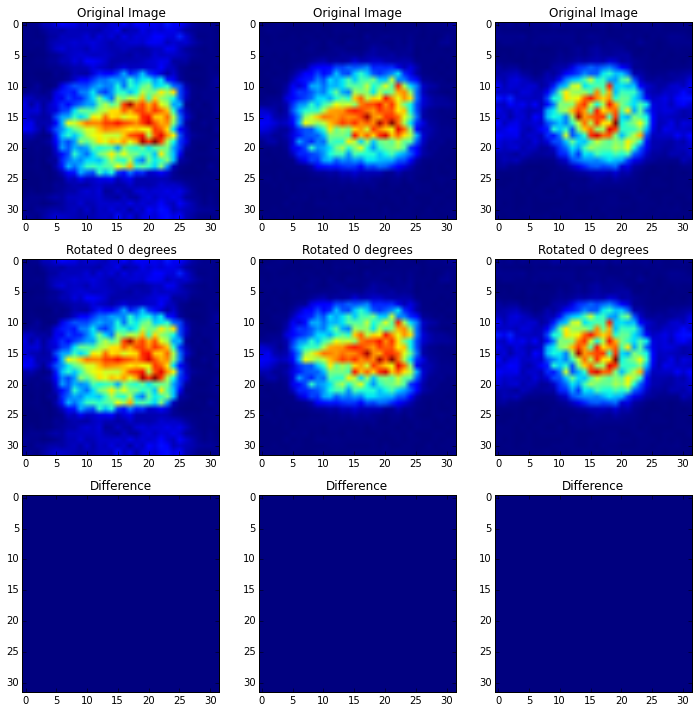

In [167]:
# rotation by 0 degrees about all axes, should return itself
t = np.zeros([3,])
vol1_rot = volrotate(vol1,0,0,0,t)
fig, ax = plt.subplots(3,3)
fig.set_figwidth(12)
fig.set_figheight(12)
[ax[0][i].imshow(vol1.max(axis=i)) for i in xrange(3)]
[ax[0][i].set_title('Original Image') for i in xrange(3)]
[ax[1][i].imshow(vol1_rot.max(axis=i)) for i in xrange(3)]
[ax[1][i].set_title('Rotated 0 degrees') for i in xrange(3)]
[ax[2][i].imshow((vol1_rot-vol1).max(axis=i)) for i in xrange(3)]
[ax[2][i].set_title('Difference') for i in xrange(3)]
plt.show()
plt.close(fig)

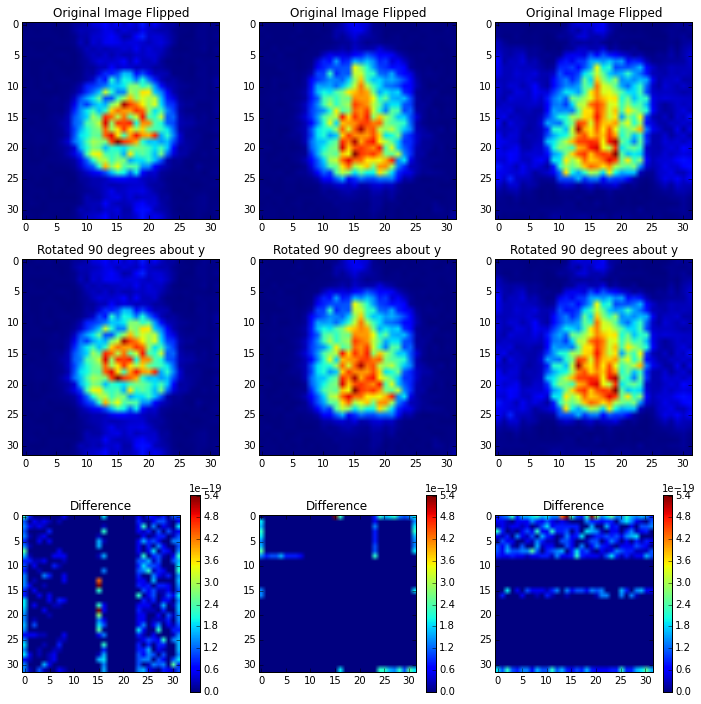

In [169]:
# rotation by 90 degrees about the y_axis, should return itselfc
t = np.zeros([3,])
vol1_rot = volrotate(vol1,90,0,0,t)
vol1_flip = np.flipud(vol1).T
fig, ax = plt.subplots(3,3)
fig.set_figwidth(12)
fig.set_figheight(12)
[ax[0][i].imshow(vol1_flip.max(axis=i)) for i in xrange(3)]
[ax[0][i].set_title('Original Image Flipped') for i in xrange(3)]
[ax[1][i].imshow(vol1_rot.max(axis=i)) for i in xrange(3)]
[ax[1][i].set_title('Rotated 90 degrees about y') for i in xrange(3)]
for i in xrange(3):
    axx = ax[2][i].imshow((vol1_rot-vol1_flip).max(axis=i))
    ax[2][i].set_title('Difference')
    plt.axes(ax[2][i]) 
    fig.colorbar(axx)
plt.show()
plt.close(fig)

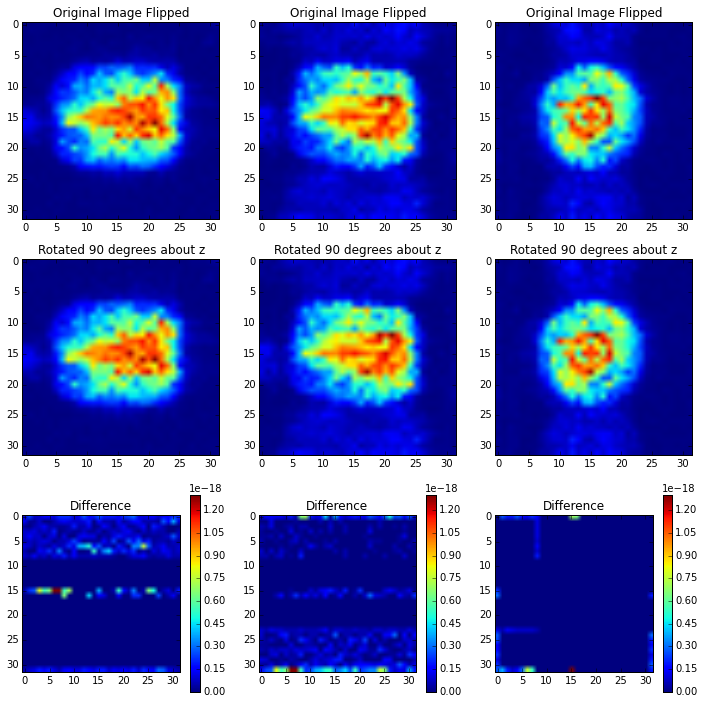

In [170]:
# rotation by 90 degrees about the x_axis, should return itself
t = np.zeros([3,])
vol1_rot = volrotate(vol1,0,0,90,t)
vol1_flip = np.rot90(vol1,1)
fig, ax = plt.subplots(3,3)
fig.set_figwidth(12)
fig.set_figheight(12)
[ax[0][i].imshow(vol1_flip.max(axis=i)) for i in xrange(3)]
[ax[0][i].set_title('Original Image Flipped') for i in xrange(3)]
[ax[1][i].imshow(vol1_rot.max(axis=i)) for i in xrange(3)]
[ax[1][i].set_title('Rotated 90 degrees about z') for i in xrange(3)]
for i in xrange(3):
    axx = ax[2][i].imshow((vol1_rot-vol1_flip).max(axis=i))
    ax[2][i].set_title('Difference')
    plt.axes(ax[2][i]) 
    fig.colorbar(axx)
plt.show()
plt.close(fig)

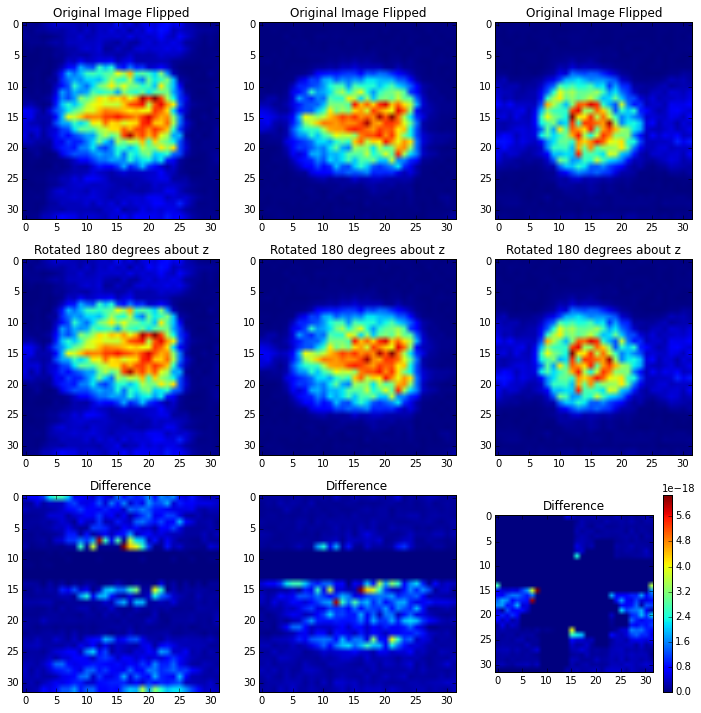

In [175]:
# rotation by 180 degrees about the x_axis, should return itself
t = np.zeros([3,])
vol1_rot = volrotate(vol1,0,0,180,t)
vol1_flip = np.flipud(np.fliplr(vol1))

fig, ax = plt.subplots(3,3)
fig.set_figwidth(12)
fig.set_figheight(12)
[ax[0][i].imshow(vol1_rot.max(axis=i)) for i in xrange(3)]
[ax[0][i].set_title('Original Image Flipped') for i in xrange(3)]
[ax[1][i].imshow(vol1_rot.max(axis=i)) for i in xrange(3)]
[ax[1][i].set_title('Rotated 180 degrees about z') for i in xrange(3)]
ax2 = []
[ax2.append(ax[2][i].imshow((vol1_rot-vol1_flip).max(axis=i))) for i in xrange(3)]
[ax[2][i].set_title('Difference') for i in xrange(3)]
fig.colorbar(ax2[0])
plt.show()
plt.close(fig)

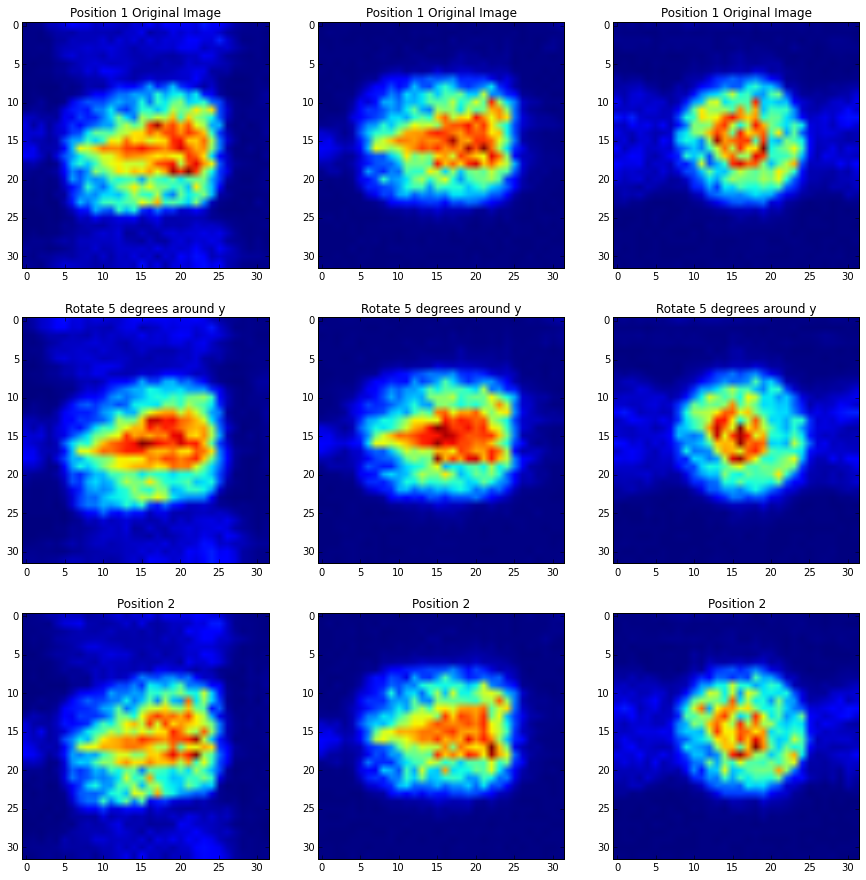

In [23]:
# Rotate the volume about the y-axis for 5 degrees
t = np.zeros([3,])
vol1_rot = volrotate(vol1,0,5,0,t)
fig, ax = plt.subplots(3,3)
fig.set_figwidth(15)
fig.set_figheight(15)
[ax[0][i].imshow(vol1.max(axis=i)) for i in xrange(3)]
[ax[0][i].set_title('Position 1 Original Image') for i in xrange(3)]
[ax[1][i].imshow(vol1_rot.max(axis=i)) for i in xrange(3)]
[ax[1][i].set_title('Rotate 5 degrees around y') for i in xrange(3)]
[ax[2][i].imshow(vol2.max(axis=i)) for i in xrange(3)]
[ax[2][i].set_title('Position 2') for i in xrange(3)]
plt.show()
plt.close(fig)

<h1>
<span style="color:red">
Quaternions in spatial rotations
</span>
</h1>

I have demonstrated how rigid body rotation in 3D around a fixed point can be represented using a multiplication of the rotation matrix around each axis. However, rotation matrices might cause confusion in many cases since one has to keep the labelling of so-called 'x', 'y', and 'z' axis consistenly. Since matrix do not have commutative law, altering the ordering in x, y and z axis will cause different resulting position. Quaternions are a nice way of avoiding this confusion. Any rigid body rotation can be represented by a single rotation by a given angle $\theta$ about a fixed axis ([Quaternions in spatial rotations](http://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation)).

Let $\boldsymbol{\mathbf{i}}$, $\boldsymbol{\mathbf{j}}$, $\boldsymbol{\mathbf{k}}$ be unit vectors representing the three Cartesian axis, then any vector $(a_x, a_y, a_z)$ can be written as $a_x\boldsymbol{\mathbf{i}} + a_y\boldsymbol{\mathbf{j}} + a_z \boldsymbol{\mathbf{k}}$. We can represent the fixed axis that the rotation is about by a unit vector $\vec{u} = (u_x, u_y, u_z) = u_x\mathbf{i} + u_y\mathbf{j} + u_z\mathbf{k}$. The quaternion for the rotation of $\theta$ about this fixed axis can now be defined as 

$$\begin{align}
\mathbf{q} &= e^{\frac{\theta}{2}{(u_x\mathbf{i} + u_y\mathbf{j} + u_z\mathbf{k})}} \\
&= \cos \frac{\theta}{2} + (u_x\mathbf{i} + u_y\mathbf{j} + u_z\mathbf{k}) \sin \frac{\theta}{2} \\
&= q_r + q_i \mathbf{i} + q_j \mathbf{i} + q_k \mathbf{i}
\end{align}$$

Now, given any vector $\mathbf{p} = (p_x, p_y, p_z) = p_x\mathbf{i} + p_y\mathbf{j} + p_z\mathbf{k}$, the new position of this vector $\mathbf{p'} = (p_x′, p_y′, p_z′)$ after rotation is

$$\mathbf{p'} = \mathbf{q} \mathbf{p} \mathbf{q}^{-1}$$

$$\begin{align*}
p' &= (q_r + q_i \mathbf{i} + q_j \mathbf{j} + q_k \mathbf{k})(p_x\mathbf{i} + p_y\mathbf{j} + p_z\mathbf{k})(q_r - (q_i \mathbf{i} + q_j \mathbf{j} + q_k \mathbf{k}))\\
\end{align*}$$
Using Hamilton product, and we know that given two vectors (a_1 + b_1i + c_1j + d_1k) and (a_2 + b_2i + c_2j + d_2k), their Hamilton product is given by,

$$
(a_1 + b_1i + c_1j + d_1k)\cdot (a_2 + b_2i + c_2j + d_2k)\\
=a_1a_2 - b_1b_2 - c_1c_2 - d_1d_2\\
{}+ (a_1b_2 + b_1a_2 + c_1d_2 - d_1c_2)\mathbf{i}\\
{}+ (a_1c_2 - b_1d_2 + c_1a_2 + d_1b_2)\mathbf{j}\\
{}+ (a_1d_2 + b_1c_2 - c_1b_2 + d_1a_2)\mathbf{k}\\
$$

In [41]:
def Hamilton_product(a1, b1, c1, d1, a2, b2, c2, d2):
    a = a1*a2-b1*b2-c1*c2-d1*d2
    i = a1*b2+b1*a2+c1*d2-d1*c2
    j = a1*c2-b1*d2+c1*a2+d1*b2
    k = a1*d2+b1*c2-c1*b2+d1*a2
    return a, i, j, k

In [158]:
def rotate_coords_quaternion(theta, ui, uj, uk, t, x, y, z):
    """
    Return the position of rotated point about quaternion u by theta degrees
    """
    ox = oy = oz = 15.5
    x, y, z = np.asarray(x) - ox, np.asarray(y) - oy, np.asarray(z) - oz
    
    # convert degrees to radians
    theta = to_radian(theta)
    qr = np.cos(theta/2.)
    s = np.sin(theta/2.)
    
    # coefficients for q and q^-1
    a1 = qr
    b1 = ui*s
    c1 = uj*s
    d1 = uk*s

    # calculate q*p*q^-1
    qp_a1, qp_b1, qp_c1, qp_d1 = Hamilton_product(a1,b1,c1,d1,0,x,y,z)
    
    # calculate final coordinates
    a, b, c, d = Hamilton_product(qp_a1, qp_b1, qp_c1, qp_d1,a1,-b1,-c1,-d1)
    
    return b + t[0] + ox, c + t[1] + oy, d + t[1] + oz

def volrotate_quaternion(volume, theta, ui, uj, uk,  t, mask=False):
    """
    Rotate a given volume by theta degrees about the unit quarternion u
    """
    # find center of the volume
    ox = volume.shape[1]/2.-0.5
    oy = volume.shape[0]/2.-0.5
    oz = volume.shape[2]/2.-0.5
    
    x = np.linspace(0, volume.shape[1]-1, volume.shape[1]).astype(int)
    y = np.linspace(0, volume.shape[0]-1, volume.shape[0]).astype(int)
    z = np.linspace(0, volume.shape[2]-1, volume.shape[2]).astype(int)
    xx, yy, zz = np.meshgrid(x, y, z)
    
    dest_x, dest_y, dest_z = rotate_coords_quaternion(theta, ui, uj, uk, t, xx, yy, zz)
    
    dest = trilinear_interp(volume, dest_x, dest_y, dest_z)
    
    if(mask):
        dest = sphere_mask(dest)
    return dest

In [156]:
# Rotation using rotation matrix translated from quarternions
def rotation_matrix_fromq(theta, ui, uj, uk):
    c = np.cos(theta)
    s = np.sin(theta)
    rotMatrix = np.zeros([3,3])
    
    rotMatrix[0][0] = c + ui**2*(1-c)
    rotMatrix[0][1] = ui*uj*(1-c) - uk*s
    rotMatrix[0][2] = ui*uk*(1-c) - uj*s

    rotMatrix[1][0] = uj*ui*(1-c) + uk*s
    rotMatrix[1][1] = c + uj**2*(1-c)
    rotMatrix[1][2] = uj*uk*(1-c) - ui*s

    rotMatrix[2][0] = uk*ui*(1-c) - uj*s
    rotMatrix[2][1] = uk*uj*(1-c) - ui*s
    rotMatrix[2][2] = c + uk**2*(1-c)
    
    return rotMatrix

def rotate_coords_q(x, y, z, theta, ui, uj, uk, t, ox, oy, oz):
    """
    Rotate arrays of coordinates x, y and z about the point (ox, oy, oz)
    using quaternion converted rotation matrix
    """

    R = rotation_matrix_fromq(theta, ui, uj, uk)
    x, y, z = np.asarray(x) - ox, np.asarray(y) - oy, np.asarray(z) - oz
    return (R[0][0]*x + R[0][1]*y + R[0][2]*z + t[0]) + ox, (R[1][0]*x + R[1][1]*y + R[1][2]*z + t[1]) + oy, (R[2][0]*x + R[2][1]*y + R[2][2]*z + t[2]) + oz


def volrotate_q(volume, theta, ui, uj, uk, t, mask=False):
    theta = to_radian(theta)
    # find center of the volume
    ox = volume.shape[1]/2.-0.5
    oy = volume.shape[0]/2.-0.5
    oz = volume.shape[2]/2.-0.5
    
    x = np.linspace(0, volume.shape[1]-1, volume.shape[1]).astype(int)
    y = np.linspace(0, volume.shape[0]-1, volume.shape[0]).astype(int)
    z = np.linspace(0, volume.shape[2]-1, volume.shape[2]).astype(int)
    xx, yy, zz = np.meshgrid(x, y, z)

    dest_x, dest_y, dest_z = rotate_coords_q(xx, yy, zz, theta, ui, uj, uk, t, ox, oy, oz)
    dest = trilinear_interp(volume, dest_x, dest_y, dest_z)
    
    if(mask):
        dest = sphere_mask(dest)
    return dest

##Test Quaternion rotate##

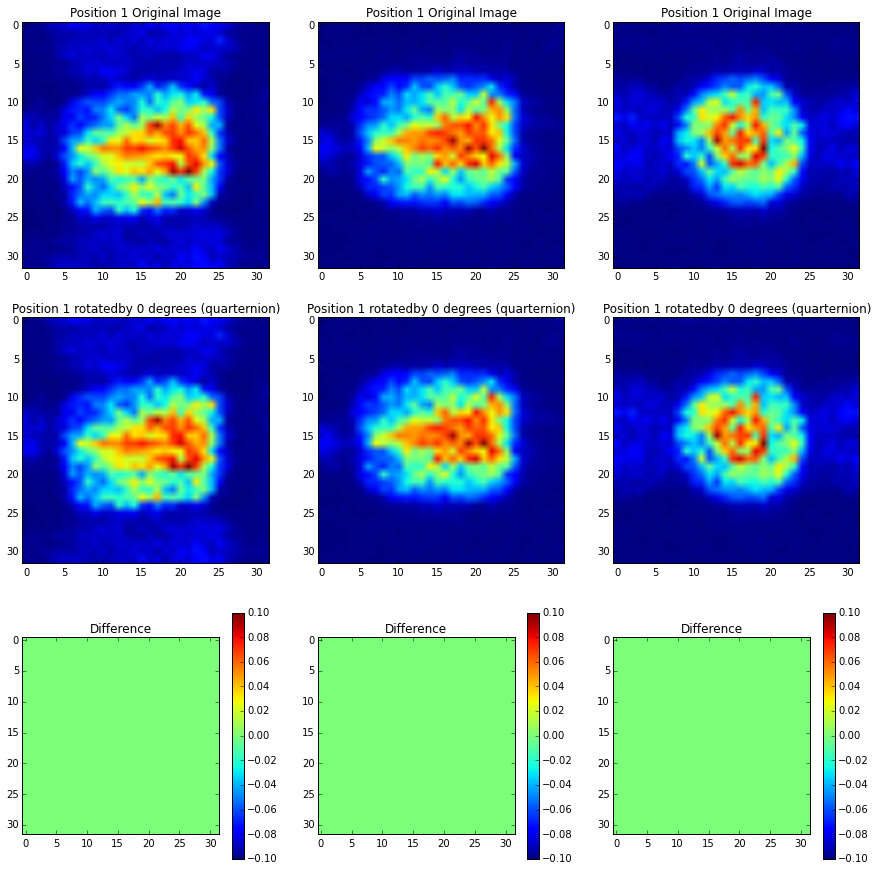

In [161]:
# rotate the image by 0 degrees, should return itself
t = np.zeros([3,])
vol1_quat = volrotate_quaternion(vol1,0,0,0,0,t)
fig, ax = plt.subplots(3,3)
fig.set_figwidth(15)
fig.set_figheight(15)
[ax[0][i].imshow(vol1.max(axis=i)) for i in xrange(3)]
[ax[0][i].set_title('Position 1 Original Image') for i in xrange(3)]
[ax[1][i].imshow(vol1_quat.max(axis=i)) for i in xrange(3)]
[ax[1][i].set_title('Position 1 rotatedby 0 degrees (quarternion)') for i in xrange(3)]

for i in xrange(3):
    axx = ax[2][i].imshow((vol1_quat-vol1).max(axis=i))
    ax[2][i].set_title('Difference')
    plt.axes(ax[2][i]) 
    fig.colorbar(axx)

plt.show()
plt.close(fig)

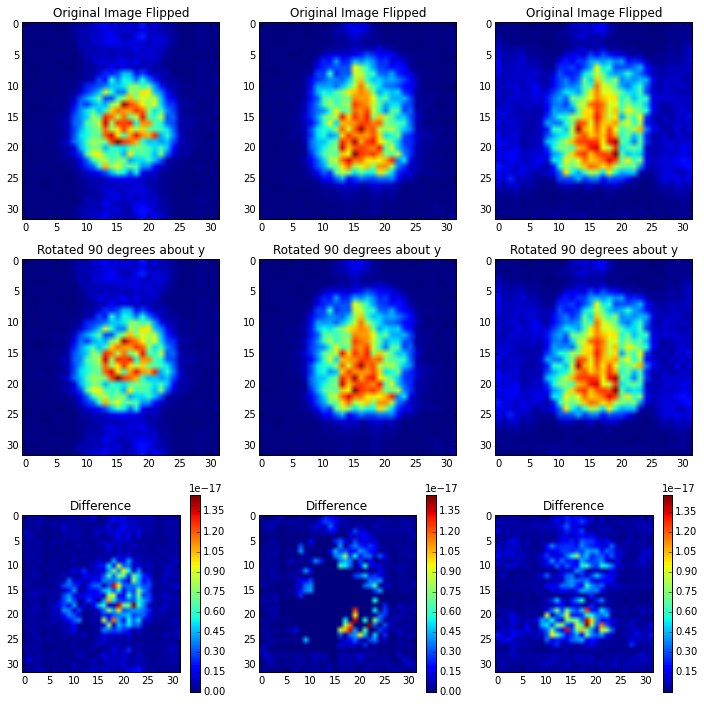

In [177]:
# rotation by 90 degrees about the y_axis, should return itselfc
t = np.zeros([3,])
vol1_rot = volrotate_quaternion(vol1,90,1,0,0,t)
vol1_flip = np.flipud(vol1).T
fig, ax = plt.subplots(3,3)
fig.set_figwidth(12)
fig.set_figheight(12)
[ax[0][i].imshow(vol1_flip.max(axis=i)) for i in xrange(3)]
[ax[0][i].set_title('Original Image Flipped') for i in xrange(3)]
[ax[1][i].imshow(vol1_rot.max(axis=i)) for i in xrange(3)]
[ax[1][i].set_title('Rotated 90 degrees about y') for i in xrange(3)]
for i in xrange(3):
    axx = ax[2][i].imshow((vol1_rot-vol1_flip).max(axis=i))
    ax[2][i].set_title('Difference')
    plt.axes(ax[2][i]) 
    fig.colorbar(axx)
plt.show()
plt.close(fig)

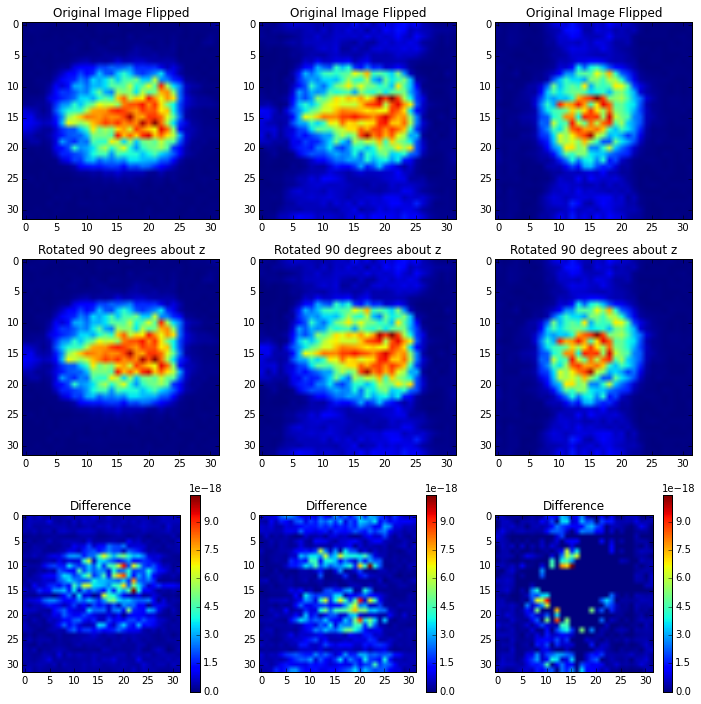

In [179]:
# rotation by 90 degrees about the x_axis, should return itself
t = np.zeros([3,])
vol1_rot = volrotate_quaternion(vol1,90,0,0,1,t)
vol1_flip = np.rot90(vol1,1)
fig, ax = plt.subplots(3,3)
fig.set_figwidth(12)
fig.set_figheight(12)
[ax[0][i].imshow(vol1_flip.max(axis=i)) for i in xrange(3)]
[ax[0][i].set_title('Original Image Flipped') for i in xrange(3)]
[ax[1][i].imshow(vol1_rot.max(axis=i)) for i in xrange(3)]
[ax[1][i].set_title('Rotated 90 degrees about z') for i in xrange(3)]
for i in xrange(3):
    axx = ax[2][i].imshow((vol1_rot-vol1_flip).max(axis=i))
    ax[2][i].set_title('Difference')
    plt.axes(ax[2][i]) 
    fig.colorbar(axx)
plt.show()
plt.close(fig)

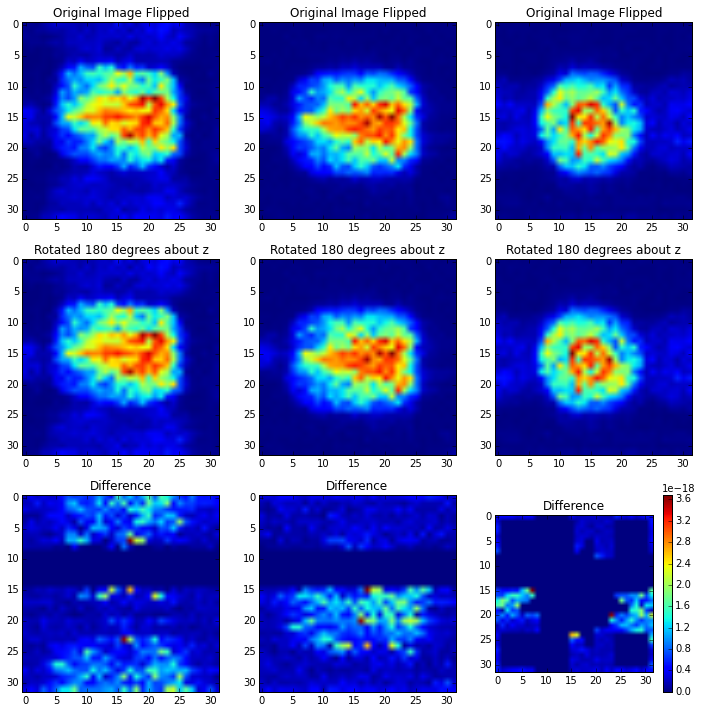

In [180]:
# rotation by 180 degrees about the x_axis, should return itself
t = np.zeros([3,])
vol1_rot = volrotate_quaternion(vol1,180,0,0,1,t)
vol1_flip = np.flipud(np.fliplr(vol1))

fig, ax = plt.subplots(3,3)
fig.set_figwidth(12)
fig.set_figheight(12)
[ax[0][i].imshow(vol1_rot.max(axis=i)) for i in xrange(3)]
[ax[0][i].set_title('Original Image Flipped') for i in xrange(3)]
[ax[1][i].imshow(vol1_rot.max(axis=i)) for i in xrange(3)]
[ax[1][i].set_title('Rotated 180 degrees about z') for i in xrange(3)]
ax2 = []
[ax2.append(ax[2][i].imshow((vol1_rot-vol1_flip).max(axis=i))) for i in xrange(3)]
[ax[2][i].set_title('Difference') for i in xrange(3)]
fig.colorbar(ax2[0])
plt.show()
plt.close(fig)

#Cost Functions#

In [181]:
def cf_ssd(J, I):
    return np.sum((J-I)**2)
def cf_L2(J, I):
    return np.linalg.norm(J-I)
def cf_L1(J, I):
    L1 = np.reshape((J-I), [1,-1])
    return np.max(L1)

In [186]:
def vol_cost_func(vol1, vol2, thetas, t, cf, arg, ax, interpolation='trilinear',rotate = None, mask=False):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    cost_func = np.zeros(len(thetas))
    for idx, th in enumerate(thetas):
        if(rotate == 'q'):
            new_vol2 = volrotate_quaternion(vol2, th, 0, 1, 0, t)
        else:
            new_vol2 = volrotate(vol2, 0, th, 0, t, interpolation)
        cost_func[idx] = cf(new_vol2,vol1)
    angMin = thetas[np.argmin(cost_func)]
    ax.plot(thetas,cost_func,label='Min angle = %s' % (angMin))
    ax.set_title('%s Cost function with bilinear interpolation' % (arg), fontsize=14)
    ax.set_xlabel('Angle (degrees)')
    ax.set_ylabel('Cost function')
    ax.legend()

In [187]:
vol1 = np.memmap(path+files[0], dtype=np.float32, mode='c', shape=(32,32,32))
vol1 = np.array(vol1)
vol2 = np.memmap(path+files[5], dtype=np.float32, mode='c', shape=(32,32,32))
vol2 = np.array(vol2)

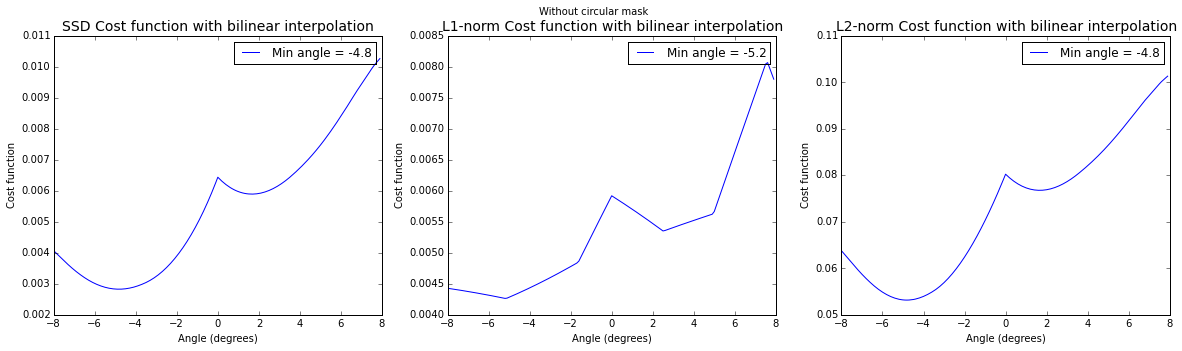

In [188]:
# Discrete Sum Cost Function with rotation matrix
thetas=np.arange(-8,8,0.1)
t = np.zeros([3,])
# without circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("Without circular mask")
vol_cost_func(vol1, vol2, thetas, t, cf_ssd, 'SSD',ax[0])
vol_cost_func(vol1, vol2, thetas, t, cf_L1, 'L1-norm',ax[1])
vol_cost_func(vol1, vol2, thetas, t, cf_L2, 'L2-norm',ax[2])
plt.show()
plt.close(fig)

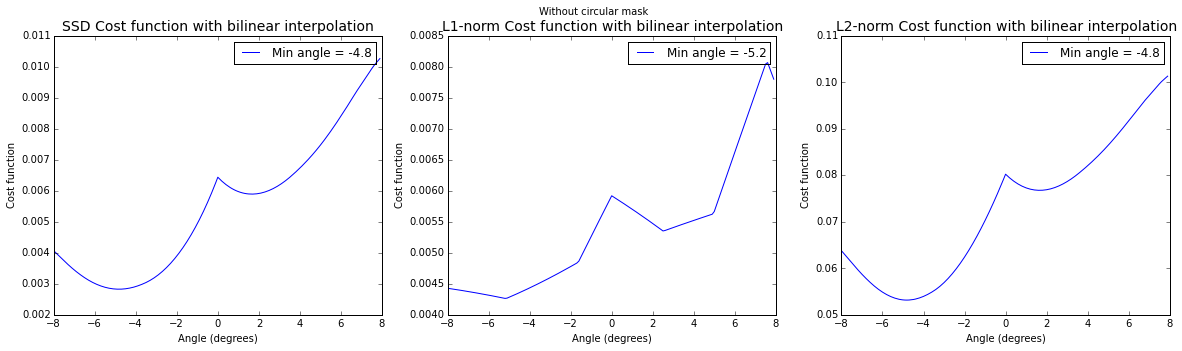

In [189]:
# Discrete Sum Cost Function with Quaternion
thetas=np.arange(-8,8,0.1)
t = np.zeros([3,])
# without circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("Without circular mask")
vol_cost_func(vol1, vol2, thetas, t, cf_ssd, 'SSD',ax[0], 'q')
vol_cost_func(vol1, vol2, thetas, t, cf_L1, 'L1-norm',ax[1], 'q')
vol_cost_func(vol1, vol2, thetas, t, cf_L2, 'L2-norm',ax[2], 'q')
plt.show()
plt.close(fig)

<header>
<h1>
<span style="color:red">
Halton Sampling
</span>
</h1>
</header>

According to Iman Aganj (Ananj 2010), using the quasi-random sampling method based on Halton sequences to compute the intergral SSD cost function can alleviate the artifacts due to grid effect when computing SSD as discrete sums because for discrete sums, only one of the two volumes is interplated and rotated, and the others remains as it is. However when using resampling to compute intergral sum, the same resampling and interpolation is done on both images.

We will use quasi-random points generated by Halton sequences to evaluate the integral SSD cost function and compare the results with the discrete sum.

Halton Sequence is a quasi-random sampling mechanism that can be used for Monte Carlo methods in estimating integrals. Halton sequences are deterministic, and they draw more well spaced samples on a given sample space. Although they are of low discrepancy, they appears to be more 'random' in many cases. I will briefly demonstrate the result of samples generated by Halton Sequences below.

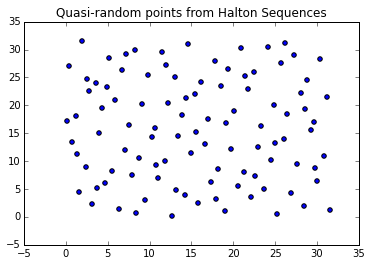

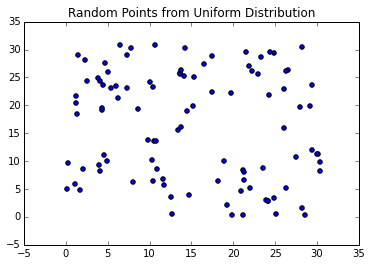

In [191]:
# Halton Sequence in 2D vs Pseudo Random Points in 2D
sequencer = ghalton.Halton(2)
points = sequencer.get(100)
pts = np.array(points)
x1 = 31*pts[:,0]
y1 = 31*pts[:,1]
plt.scatter(32*pts[:,1],32*pts[:,0])
plt.title('Quasi-random points from Halton Sequences')
plt.show()

x = np.random.uniform(low = 0.0, high = 31.0, size = 100)
y = np.random.uniform(low = 0.0, high = 31.0, size = 100)
plt.scatter(x,y)
plt.title('Random Points from Uniform Distribution')
plt.show()

Halton sequences suffers from high auto correlation with the subsequences, and in Monte Carlo integral approximation, highly auto-correlated points will lead to less effective samples. Generalized Halton Sequences addresses the problem by shuffling the extension of each number. Generalized Halton sequences performs better particularly with higher dimensions. (DeRainville 2012)

In [192]:
#Halton Samples in 3D
dim = 3
sequencer = ghalton.Halton(3)
points = sequencer.get(100)
pts = np.array(points)
x2 = 31*pts[:,0]
y2 = 31*pts[:,1]
z2 = 31*pts[:,2]

sequencer = ghalton.GeneralizedHalton(ghalton.EA_PERMS[:dim])
points = sequencer.get(100)
pts = np.array(points)
x3 = 31*pts[:,0]
y3 = 31*pts[:,1]
z3 = 31*pts[:,2]

# Random samples from uniform distribution in 3D
x = np.random.uniform(low = 0.0, high = 31.0, size = 100)
y = np.random.uniform(low = 0.0, high = 31.0, size = 100)
z = np.random.uniform(low = 0.0, high = 31.0, size = 100)

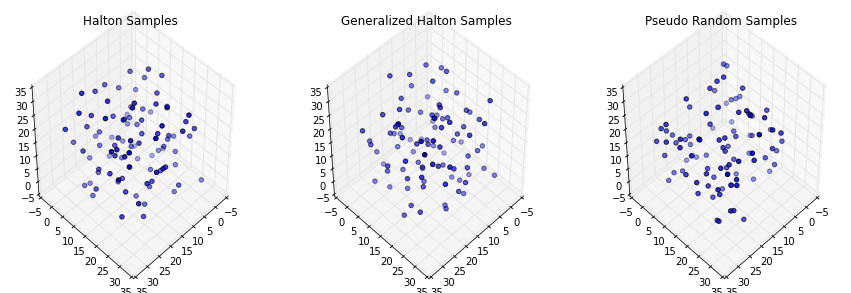

In [193]:
from mpl_toolkits.mplot3d import Axes3D

def randrange(n, vmin, vmax):
    return (vmax-vmin)*np.random.rand(n) + vmin

fig = plt.figure(figsize = [15,5])
ax = fig.add_subplot(131, projection='3d')
ax.scatter(x2, y2, z2)
ax.view_init(elev=45, azim=45)
ax.set_title('Halton Samples')

ax = fig.add_subplot(132, projection='3d')
ax.scatter(x3, y3, z3)
ax.view_init(elev=45, azim=45)
ax.set_title('Generalized Halton Samples')

ax = fig.add_subplot(133, projection='3d')
ax.scatter(x, y, z)
ax.view_init(elev=45, azim=45)
ax.set_title('Pseudo Random Samples')

plt.show()
plt.close(fig)


In [194]:
def halton_cost_func(N, vol1, vol2, thetas, t, arg, mask=False):
    '''
    N: Number of Halton Sampling Points
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    arg: string for plot titles
    '''
    cost_func = np.zeros(len(thetas))
    t0 = time.time()
    # generate Halton Sequence in the 32*32*32 grid
    sequencer = ghalton.GeneralizedHalton(ghalton.EA_PERMS[:3])
    sequencer.reset()
    points = sequencer.get(N)
    pts = np.array(points)
    x1 = 31 * pts[:,0]
    y1 = 31 * pts[:,1]
    z1 = 31 * pts[:,2]
    
    for idx, th in enumerate(thetas):
        new_vol2 = volrotate(vol2, 0, th, 0, t)
        v2 = trilinear_interp(new_vol2, x1, y1, z1)
        v1 = trilinear_interp(vol1, x1, y1, z1)
        cost_func[idx] = cf_ssd(v2,v1)
    t1 = time.time()
    print 'Time for %s halton samples is %s seconds' % (N,t1-t0) 

    angMin = thetas[np.argmin(cost_func)]
    plt.plot(thetas,cost_func,label='Min angle = %s' % (angMin))
    plt.title('Integral SSD (%s Halton Samples) with bilinear interpolation\n' % (N), fontsize=12)
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Integral SSD')
    plt.legend()
    plt.show()

Time for 100 halton samples is 1.14403390884 seconds


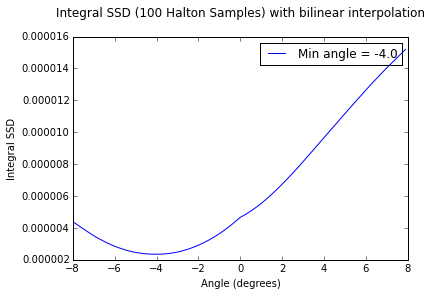

Time for 500 halton samples is 1.1740231514 seconds


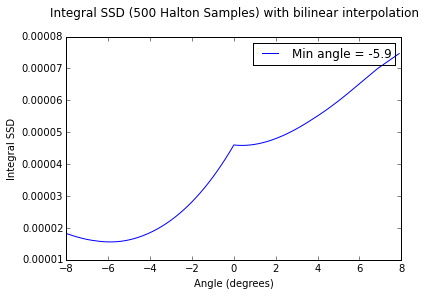

Time for 1000 halton samples is 1.28136301041 seconds


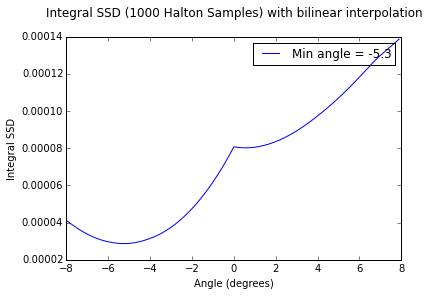

Time for 10000 halton samples is 1.73387908936 seconds


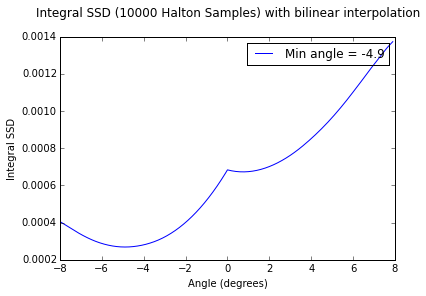

Time for 50000 halton samples is 4.29654192924 seconds


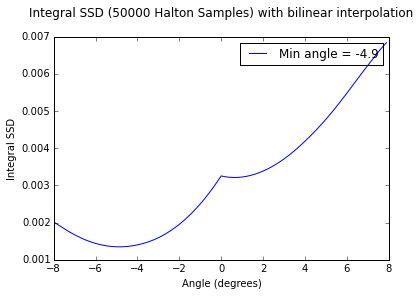

In [195]:
# Integral Cost function with Halton Sampling
t = np.zeros([3,])
thetas=np.arange(-8,8,0.1)
# without circular mask
halton_cost_func(100, vol1, vol2, thetas, t, cf_ssd, 'SSD')
halton_cost_func(500, vol1, vol2, thetas, t, cf_ssd, 'SSD')
halton_cost_func(1000, vol1, vol2, thetas, t, cf_ssd, 'SSD')
halton_cost_func(10000, vol1, vol2, thetas, t, cf_ssd, 'SSD')
halton_cost_func(50000, vol1, vol2, thetas, t, cf_ssd, 'SSD')

<span style="color:red">
In this data, halton sampling did give a slightly more accurate results than discrete sum of SSD.
</span>

#Pineapple with Translation and Rotation

In [196]:
path1 = '/Users/zyzdiana/Dropbox/vNav_Test_Data/'
files1 = get_files(os.listdir(path1))
pos1 = files1[:(len(files1)/2)]
pos2 = files1[(len(files1)/2):]
print pos1
print pos2

['Pos_1_View_1_Rep_1.dat', 'Pos_1_View_1_Rep_2.dat', 'Pos_1_View_1_Rep_3.dat', 'Pos_1_View_1_Rep_4.dat', 'Pos_1_View_1_Rep_5.dat', 'Pos_1_View_2_Rep_1.dat', 'Pos_1_View_2_Rep_2.dat', 'Pos_1_View_2_Rep_3.dat', 'Pos_1_View_2_Rep_4.dat', 'Pos_1_View_2_Rep_5.dat', 'Pos_1_View_3_Rep_1.dat', 'Pos_1_View_3_Rep_2.dat', 'Pos_1_View_3_Rep_3.dat', 'Pos_1_View_3_Rep_4.dat', 'Pos_1_View_3_Rep_5.dat']
['Pos_2_View_1_Rep_1.dat', 'Pos_2_View_1_Rep_2.dat', 'Pos_2_View_1_Rep_3.dat', 'Pos_2_View_1_Rep_4.dat', 'Pos_2_View_1_Rep_5.dat', 'Pos_2_View_2_Rep_1.dat', 'Pos_2_View_2_Rep_2.dat', 'Pos_2_View_2_Rep_3.dat', 'Pos_2_View_2_Rep_4.dat', 'Pos_2_View_2_Rep_5.dat', 'Pos_2_View_3_Rep_1.dat', 'Pos_2_View_3_Rep_2.dat', 'Pos_2_View_3_Rep_3.dat', 'Pos_2_View_3_Rep_4.dat', 'Pos_2_View_3_Rep_5.dat']


The pineapple was physically rotated between position 1 and position 2, visualize the difference.

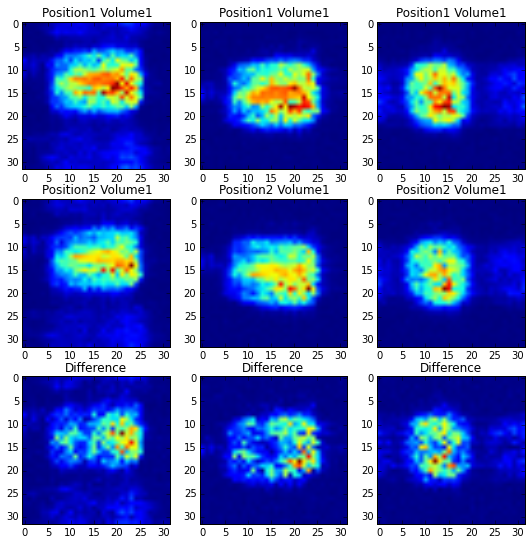

In [197]:
# Volume with Translation only
vol1 = np.memmap(path1+pos1[0], dtype=np.float32, shape=(32,32,32))
vol2 = np.memmap(path1+pos2[0], dtype=np.float32, shape=(32,32,32))
diff = vol1-vol2
fig, ax = plt.subplots(3,3)
fig.set_figwidth(9)
fig.set_figheight(9)
[ax[0][i].imshow(vol1.max(axis=i)) for i in xrange(3)]
[ax[0][i].set_title('Position1 Volume%s' % (1)) for i in xrange(3)]
[ax[1][i].imshow(vol2.max(axis=i)) for i in xrange(3)]
[ax[1][i].set_title('Position2 Volume%s' % (1)) for i in xrange(3)]
[ax[2][i].imshow(diff.max(axis=i)) for i in xrange(3)]
[ax[2][i].set_title('Difference') for i in xrange(3)]
plt.show()
plt.close(fig)

Within Position 1, the pineapple was first rotated by 5 degrees (View 2) and then translated by 10mm(View 3).

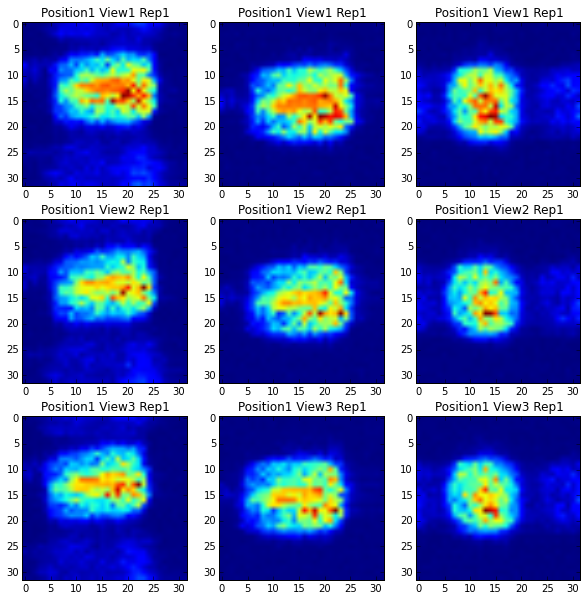

In [198]:
vol1 = np.memmap(path1+pos1[0], dtype=np.float32, shape=(32,32,32))
vol1 = np.array(vol1)
vol2 = np.memmap(path1+pos1[5], dtype=np.float32, shape=(32,32,32))
vol2 = np.array(vol2)
vol3 = np.memmap(path1+pos1[10], dtype=np.float32, shape=(32,32,32))
vol3 = np.array(vol3)
fig, ax = plt.subplots(3,3)
fig.set_figwidth(10)
fig.set_figheight(10)
[ax[0][i].imshow(vol1.max(axis=i)) for i in xrange(3)]
[ax[0][i].set_title('Position1 View1 Rep1') for i in xrange(3)]
[ax[1][i].imshow(vol2.max(axis=i)) for i in xrange(3)]
[ax[1][i].set_title('Position1 View2 Rep1') for i in xrange(3)]
[ax[2][i].imshow(vol3.max(axis=i)) for i in xrange(3)]
[ax[2][i].set_title('Position1 View3 Rep1') for i in xrange(3)]
plt.show()
plt.close(fig)

In [269]:
def volrotate(volume, gamma, beta, alpha, t, interpolation='trilinear', mask=False):
    t = np.array(t)
    # find center of the volume
    ox = volume.shape[1]/2.-0.5
    oy = volume.shape[0]/2.-0.5
    oz = volume.shape[2]/2.-0.5
    
    x = np.linspace(0, volume.shape[1]-1, volume.shape[1]).astype(int)
    y = np.linspace(0, volume.shape[0]-1, volume.shape[0]).astype(int)
    z = np.linspace(0, volume.shape[2]-1, volume.shape[2]).astype(int)
    xx, yy, zz = np.meshgrid(x, y, z)
    
    dest_x, dest_y, dest_z = rotate_coords(xx, yy, zz, gamma, beta, alpha, t, ox, oy, oz)
    if(interpolation == 'tricubic'):
        dest = tricubic_interp(volume, dest_x, dest_y, dest_z)
    else:
        dest = trilinear_interp(volume, dest_x, dest_y, dest_z)
    
    if(mask):
        dest = sphere_mask(dest)

    return dest

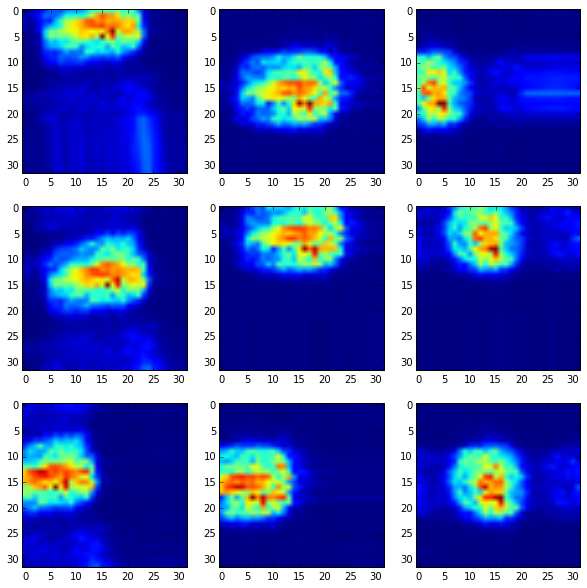

In [270]:
# Test Translation
fig, ax = plt.subplots(3,3)
fig.set_figwidth(10)
fig.set_figheight(10)
t_vol3 = volrotate(vol3, 0, 5, 0, [10,0,0])
[ax[0][i].imshow(t_vol3.max(axis=i)) for i in xrange(3)]
t_vol3 = volrotate(vol3, 0, 5, 0, [0,10,0])
[ax[1][i].imshow(t_vol3.max(axis=i)) for i in xrange(3)]
t_vol3 = volrotate(vol3, 0, 5, 0, [0,0,10])
[ax[2][i].imshow(t_vol3.max(axis=i)) for i in xrange(3)]
plt.show()
plt.close(fig)

Use the cost function to compute rotation and translation

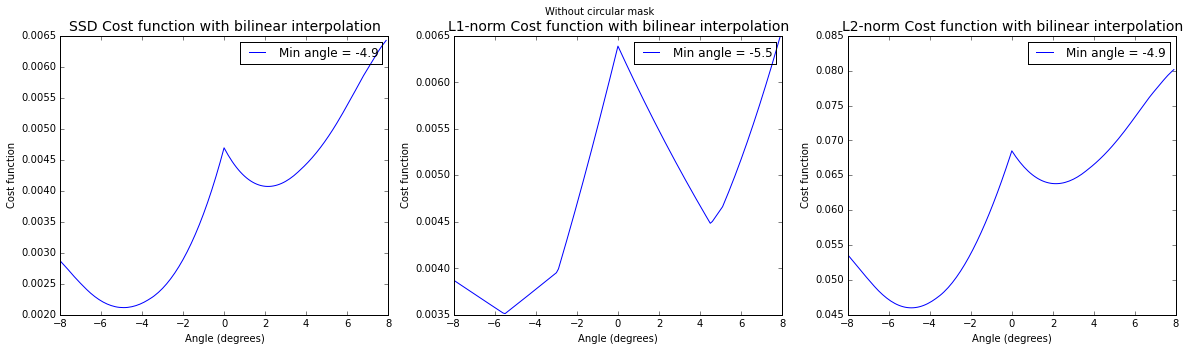

In [203]:
# Rotation First with Quaternion

# Discrete Sum Cost Function
t = np.zeros([3,])
thetas=np.arange(-8,8,0.1)
# without circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("Without circular mask")
vol_cost_func(vol1, vol2, thetas, t, cf_ssd, 'SSD',ax[0], rotate='q')
vol_cost_func(vol1, vol2, thetas, t, cf_L1, 'L1-norm',ax[1], rotate='q')
vol_cost_func(vol1, vol2, thetas, t, cf_L2, 'L2-norm',ax[2], rotate='q')
plt.show()
plt.close(fig)

Time for 100 halton samples is 1.17944407463 seconds


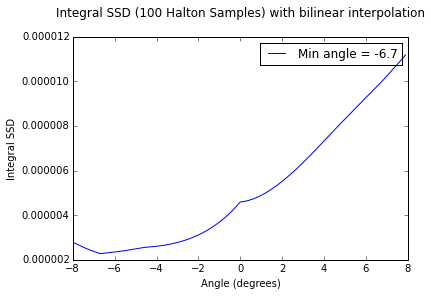

Time for 500 halton samples is 1.23535609245 seconds


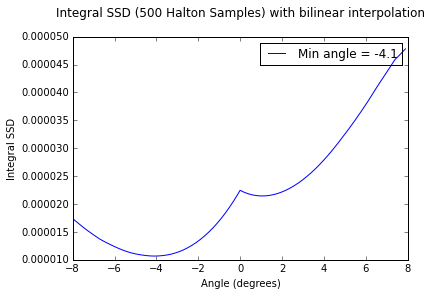

Time for 1000 halton samples is 1.32402205467 seconds


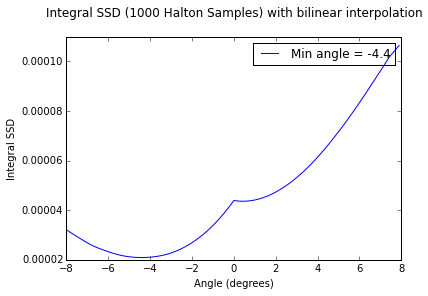

Time for 10000 halton samples is 1.74204015732 seconds


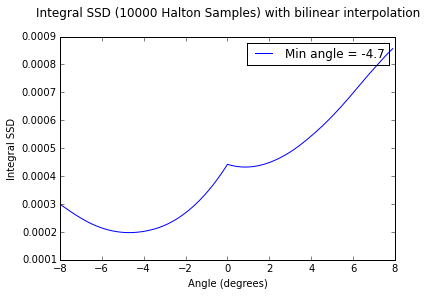

Time for 50000 halton samples is 4.49492096901 seconds


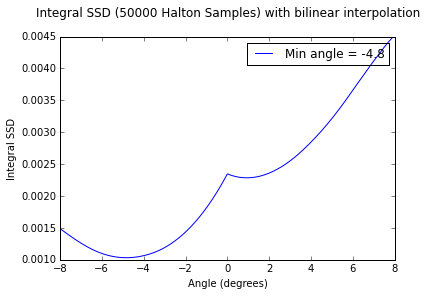

In [204]:
# Integral Cost function with Halton Sampling
t = np.zeros([3,])
thetas=np.arange(-8,8,0.1)
# without circular mask
halton_cost_func(100, vol1, vol2, thetas, t, cf_ssd, 'SSD')
halton_cost_func(500, vol1, vol2, thetas, t, cf_ssd, 'SSD')
halton_cost_func(1000, vol1, vol2, thetas, t, cf_ssd, 'SSD')
halton_cost_func(10000, vol1, vol2, thetas, t, cf_ssd, 'SSD')
halton_cost_func(50000, vol1, vol2, thetas, t, cf_ssd, 'SSD')

<span style="color:red">
Unlike the previous data, for this image, halton sampling actully performed worse than the sum of SSD
</span>

In [226]:
def vol_cost_func_t(vol1, vol2, theta, t, cf, arg, ax, rotate = None, mask=False):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    t: list of translation to try
    cf: cost function
    arg: string for plot titles
    '''
    cost_func = np.zeros(len(t))
    for idx, th in enumerate(t):
        if(rotate == 'q'):
            new_vol2 = volrotate_q(vol2, theta, 0, 1, 0, th)
        else:
            new_vol2 = volrotate(vol2, 0, theta, 0, th)
        cost_func[idx] = cf(new_vol2,vol1)
    tMin = t[np.argmin(cost_func)]
    t = np.array(t)
    ax.plot(np.array(t*8.)[:,2],cost_func,label='Min translation = %s' % (tMin*8.))
    ax.set_title('%s Cost function with bilinear interpolation' % (arg), fontsize=14)
    ax.set_xlabel('Translation (mm)')
    ax.set_ylabel('Cost function')
    ax.legend(loc=1)

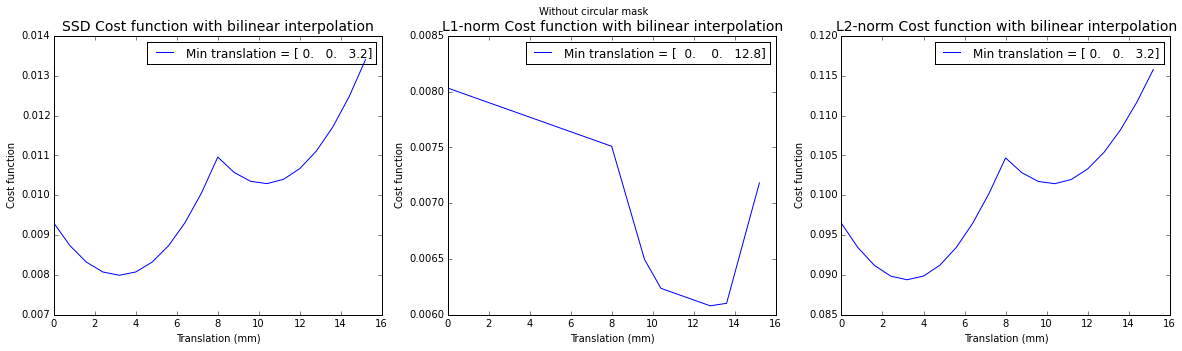

In [238]:
# Translation

# Discrete Sum Cost Function
t = []
for i in np.arange(0,2,0.1):
    t.append(np.array([0,0,i]))
thetas = 0.0
# without circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("Without circular mask")
vol_cost_func_t(vol2, vol3, thetas, t, cf_ssd, 'SSD',ax[0])
vol_cost_func_t(vol2, vol3, thetas, t, cf_L1, 'L1-norm',ax[1])
vol_cost_func_t(vol2, vol3, thetas, t, cf_L2, 'L2-norm',ax[2])
plt.show()
plt.close(fig)

In [222]:
def halton_cost_func_t(N, vol1, vol2, theta, t, arg, mask=False):
    '''
    N: Number of Halton Sampling Points
    vol1: original image
    vol2: volume to be rotated
    theta: rotation by degrees
    t: list of translations to try
    arg: string for plot titles
    '''
    cost_func = np.zeros(len(t))
    t0 = time.time()
    # generate Halton Sequence in the 32*32*32 grid
    sequencer = ghalton.GeneralizedHalton(ghalton.EA_PERMS[:3])
    sequencer.reset()
    points = sequencer.get(N)
    pts = np.array(points)
    x1 = 31 * pts[:,0]
    y1 = 31 * pts[:,1]
    z1 = 31 * pts[:,2]

    for idx, th in enumerate(t):
        new_vol2 = volrotate(vol2, 0, theta, 0, th)
        v2 = trilinear_interp(new_vol2, x1, y1, z1)
        v1 = trilinear_interp(vol1, x1, y1, z1)
        cost_func[idx] = cf_ssd(v2,v1)
    t1 = time.time()
    print 'Time for %s halton samples is %s seconds' % (N,t1-t0) 

    tMin = t[np.argmin(cost_func)]
    t = np.array(t)
    plt.plot(np.array(t*8.)[:,2],cost_func,label='Min translation = %s' % (tMin*8.))
    plt.title('%s Cost function with bilinear interpolation' % (arg), fontsize=14)
    plt.xlabel('Translation (mm)')
    plt.ylabel('Cost function')
    plt.legend(loc=1)
    plt.show()

Time for 100 halton samples is 0.145144939423 seconds


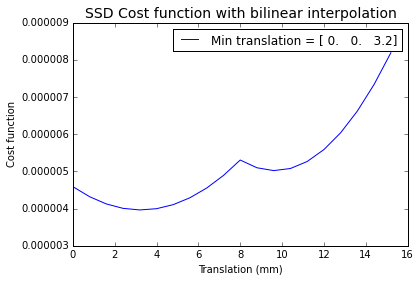

Time for 500 halton samples is 0.155055046082 seconds


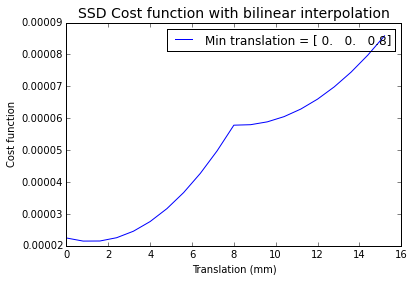

Time for 1000 halton samples is 0.15846991539 seconds


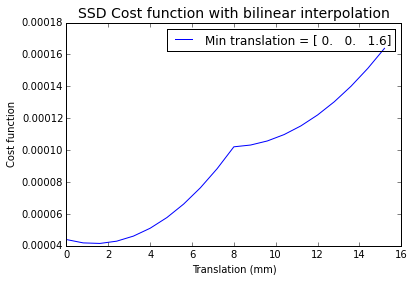

In [237]:
# Integral Cost function with Halton Sampling
t = []
for i in np.arange(0,2,0.1):
    t.append(np.array([0,0,i]))
thetas = 0.0
# without circular mask
halton_cost_func_t(100, vol1, vol2, thetas, t, 'SSD')
halton_cost_func_t(500, vol1, vol2, thetas, t, 'SSD')
halton_cost_func_t(1000, vol1, vol2, thetas, t, 'SSD')

Within Position 2, the pineapple was first rotated by 15 degrees (View 2) and then translated by 10mm(View 3).

In [ ]:
vol1 = np.memmap(path1+pos2[0], dtype=np.float32, shape=(32,32,32))
vol1 = np.array(vol1)
vol2 = np.memmap(path1+pos2[5], dtype=np.float32, shape=(32,32,32))
vol2 = np.array(vol2)
vol3 = np.memmap(path1+pos2[10], dtype=np.float32, shape=(32,32,32))
vol3 = np.array(vol3)
fig, ax = plt.subplots(3,3)
fig.set_figwidth(10)
fig.set_figheight(10)
[ax[0][i].imshow(vol1.max(axis=i)) for i in xrange(3)]
[ax[0][i].set_title('Position1 View1 Rep1') for i in xrange(3)]
[ax[1][i].imshow(vol2.max(axis=i)) for i in xrange(3)]
[ax[1][i].set_title('Position1 View2 Rep1') for i in xrange(3)]
[ax[2][i].imshow(vol3.max(axis=i)) for i in xrange(3)]
[ax[2][i].set_title('Position1 View3 Rep1') for i in xrange(3)]
plt.show()
plt.close(fig)

In [ ]:
# Rotation First

# Discrete Sum Cost Function
t = np.zeros([3,])
thetas=np.arange(-25,10,0.2)
# without circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle("Without circular mask")
vol_cost_func(vol1, vol2, thetas, t, cf_ssd, 'SSD',ax[0])
vol_cost_func(vol1, vol2, thetas, t, cf_L1, 'L1-norm',ax[1])
vol_cost_func(vol1, vol2, thetas, t, cf_L2, 'L2-norm',ax[2])
plt.show()
plt.close(fig)

<span style="color:red">
As the rotation gets larger, the we are getting more accurate results on detection of rotation.
</span>

In [ ]:
# Integral Cost function with Halton Sampling
t = np.zeros([3,])
thetas=np.arange(-20,-10,0.1)
# without circular mask
halton_cost_func(100, vol1, vol2, thetas, t, cf_ssd, 'SSD')
halton_cost_func(500, vol1, vol2, thetas, t, cf_ssd, 'SSD')
halton_cost_func(1000, vol1, vol2, thetas, t, cf_ssd, 'SSD')
halton_cost_func(10000, vol1, vol2, thetas, t, cf_ssd, 'SSD')
halton_cost_func(50000, vol1, vol2, thetas, t, cf_ssd, 'SSD')

In [ ]:
vol1 = np.memmap(path1+files1[0], dtype=np.float32, shape=(32,32,32))
vol2 = np.memmap(path1+files1[1], dtype=np.float32, shape=(32,32,32))
vol3 = np.memmap(path1+files1[2], dtype=np.float32, shape=(32,32,32))
vol4 = np.memmap(path1+files1[3], dtype=np.float32, shape=(32,32,32))
vol5 = np.memmap(path1+files1[4], dtype=np.float32, shape=(32,32,32))
fig, ax = plt.subplots(5,3)
fig.set_figwidth(10)
fig.set_figheight(15)
[ax[0][i].imshow(vol1.max(axis=i)) for i in xrange(3)]
[ax[0][i].set_title('Position1 View1 Rep 1') for i in xrange(3)]
[ax[1][i].imshow(vol2.max(axis=i)) for i in xrange(3)]
[ax[1][i].set_title('Position1 View1 Rep 2') for i in xrange(3)]
[ax[2][i].imshow(vol3.max(axis=i)) for i in xrange(3)]
[ax[2][i].set_title('Position1 View1 Rep 3') for i in xrange(3)]
[ax[3][i].imshow(vol4.max(axis=i)) for i in xrange(3)]
[ax[3][i].set_title('Position1 View1 Rep 4') for i in xrange(3)]
[ax[4][i].imshow(vol5.max(axis=i)) for i in xrange(3)]
[ax[4][i].set_title('Position1 View1 Rep 5') for i in xrange(3)]
plt.show()
plt.close(fig)

#Noise Model#
##With Real Complex-Valued Signal##

**Basic Assumptions:**

- Each voxel is independent.
- The signal source the obejct being scanned is a fixed parameter, not a random variable, hence we can ignore spatial correlation in the signal source itself.

**Signal model without noise:**

Let s be the complex-valued signal, and $\boldsymbol{y}$ denote the complex-valued vector of measurements from the voxel. We know that the signal values are measured with a C-dimensional complex vector by the C channels of the head coil, so at each voxel there is a complex valued sensitivity from all of the channels, we denote this sensitivity vector as $\boldsymbol{c}$. Then the ideal signal model without any noise is $$\boldsymbol{y} = \boldsymbol{c}s$$


**Noise model:**

Noise in the MRI measurement is circular, zero-mean, complex-Gaussian distributed, that is, the real and complex part of the noise are iid, and noise at one voxel is independent of all the other voxels. Noises at each voxel share the same variance structure. However, the noise within one voxel from the various channels are not independent, thus we can write the pdf of the the measurement $\boldsymbol{y}$, given the true signal s, the channel sensitivity vector $\boldsymbol{c}$, and the real-valued noise covariance matrix $\boldsymbol{\Sigma}$ as follows,

$$ p(\boldsymbol{y}|s,\boldsymbol{c}, \boldsymbol{\Sigma}) = \frac{1}{(2\pi)^{\frac{C}{2}}\sqrt{|\boldsymbol{\Sigma}|}} \exp[-(\boldsymbol{y}-\boldsymbol{c}s)^T\boldsymbol{\Sigma}^{-1}(\boldsymbol{y}-\boldsymbol{c}s)]$$